#### Import Libraries & Set Config

In [49]:
# data tools
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, date

# stats tools
from scipy.optimize import minimize
import statsmodels.api as sm
from functools import reduce
import datetime

# visualization tools
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# misc tools
import tqdm
import os

In [50]:
# Plotting color config setup
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'

#### Define Model

In [51]:
class FactorModel:
    """
    A class to handle data loading, factor calculation, portfolio formation, and
    backtesting against factor models.
    """

    def __init__(self,
                 start=datetime.date(1970, 12, 31),
                 end=datetime.date(2024, 12, 31)):
        self.start, self.end = start, end
        self.factors_df = None
        self.portfolios_df = None
        self.n_quantiles = -1
        self.data = None
        
        self.load_data()
        if self.data is not None:
            self.compute_factors()

    # 1. FACTOR MODELING

    def load_data(self):
        def _load_compustat():
            comp = pl.read_csv("data/compustat_1970.csv", null_values=[''], ignore_errors=True)
            comp.columns = [col.lower() for col in comp.columns]
            return comp.with_columns(pl.col("public_date").str.to_date().alias("date")).drop_nulls("date")

        def _load_crsp():
            na_values = [chr(i) for i in range(65, 91)]
            crsp = pl.read_csv("data/crsp_1964.csv", null_values=na_values, ignore_errors=True)
            crsp.columns = [col.lower() for col in crsp.columns]
            return crsp.with_columns(pl.col("date").str.to_date().alias("date")).drop_nulls("date")
        
        def _load_rf_rates():
            rf = pl.read_csv("data/risk_free_rates.csv")
            return rf.with_columns(pl.col("dateff").str.to_date().alias("date"))

        try:
            crsp = _load_crsp().sort('permno', 'date', maintain_order=True)
            comp = _load_compustat().sort('permno', 'date', maintain_order=True)
            rf = _load_rf_rates().sort('date', maintain_order=True)
            data = crsp.join(comp, on=["permno", "date"], how="inner").join(rf, on="date")
            self.data = (
                data.sort('permno', 'date', maintain_order=True)
                .filter(
                    pl.col('date').is_between(self.start, self.end) &
                    pl.col('prc').is_not_null() &
                    pl.col('prc').abs().gt(5) &  # price > $5
                    (pl.col('shrout') * pl.col('prc').abs()).gt(1000)  # market cap > $1M
                )
                .unique(['permno', 'date'], keep='last', maintain_order=True) 
            )

            duplicates = self.data.group_by(['permno', 'date']).agg(pl.len().alias('count')).filter(pl.col('count') > 1)

        except Exception as e:
            print(f"Error reading or processing data files: {e}")
            self.data = None

    def compute_factors(self):
        if self.data is None or self.data.is_empty():
            print("Data is not available. Cannot compute factors.")
            return

        monthly_snapshot = self.data.sort('permno', 'date').group_by_dynamic(
            'date', every='1mo', group_by='permno'
        ).agg([
            (pl.col('ret') + 1).product().alias('ret_prod'), pl.last('prc'), pl.last('shrout'),
            pl.last('bm'), pl.last('gprof'), pl.last('accrual'), pl.last('totdebt_invcap'),
            pl.last('equity_invcap'), pl.last('vwretd')
        ]).with_columns((pl.col('ret_prod') - 1).alias('ret')).drop('ret_prod')

        monthly_df = monthly_snapshot.sort('permno', 'date').with_columns(
            pl.col(['bm', 'gprof', 'accrual', 'totdebt_invcap', 'equity_invcap']).forward_fill().over('permno')
        )
        
        window_size = 36
        factors_df = (
            monthly_df.sort('permno', 'date')
            .with_columns([
                (pl.rolling_cov("vwretd", "ret", window_size=window_size) / pl.col("vwretd").rolling_var(window_size=window_size)).over("permno").alias("beta"),
                (pl.col('shrout') * pl.col('prc').abs()).shift(1).over('permno').alias('me'),
                (pl.col('totdebt_invcap') + pl.col('equity_invcap')).alias('invcap'),
            ]).with_columns([
                (pl.col('invcap') / pl.col('invcap').shift(12).over('permno') - 1).alias('investment'),
                ((pl.col('ret') + 1).cum_prod().over('permno') / (pl.col('ret') + 1).cum_prod().over('permno').shift(11)).alias('ret_11m_prod')
            ]).with_columns([
                (pl.col('ret_11m_prod').shift(2).over('permno') - 1).alias('momentum')
            ]).with_columns([
                pl.col('momentum').clip(
                    pl.col('momentum').quantile(0.01).over('date'), # winsorize momentum at 1% and 99% within each date
                    pl.col('momentum').quantile(0.99).over('date')
                ).alias('momentum')
            ]).with_columns([
                (pl.col("ret") - (pl.col("beta") * pl.col("vwretd"))).alias("residual"),
            ]).with_columns([
                pl.col("residual").rolling_std(window_size=12).over("permno").alias("idiosyncratic_risk"),
            ])
        )

        self.factors_df = factors_df.select([
            'permno', 'date', 'ret', 'beta', pl.col('me').alias('size'), pl.col('bm').alias('value'),
            'momentum', pl.col('gprof').alias('profitability'), 'investment', 'accrual', 'idiosyncratic_risk'
        ]).drop_nulls()

    def sort_into_quantiles(self, factor_names: str | list[str] | None = None, n_quantiles: int = 5):
        if self.factors_df is None: return None
        self.n_quantiles = n_quantiles
        
        if factor_names is None:
            factors_to_process = [c for c in self.factors_df.columns if c not in ['permno', 'date', 'ret']]
        else:
            factors_to_process = [factor_names] if isinstance(factor_names, str) else factor_names
    
        if missing := [f for f in factors_to_process if f not in self.factors_df.columns]:
            print(f"Error: The following factors were not found: {missing}"); return None
        
        expressions = [
            pl.col(f).qcut(n_quantiles, labels=[str(i) for i in range(1, n_quantiles + 1)], allow_duplicates=True).alias(f"portfolio_{f}")
            for f in factors_to_process
        ]
        self.portfolios_df = self.factors_df.group_by('date').map_groups(lambda g: g.with_columns(expressions))
        return self.portfolios_df

    def backtest_long_short(self, factor_name: str, weighting: str = 'ew', long_highest_quantile: bool = True):
        if self.portfolios_df is None: return None
        portfolio_col = f"portfolio_{factor_name}"
        if portfolio_col not in self.portfolios_df.columns: return None

        backtest_df = self.portfolios_df.with_columns(pl.col('ret').shift(-1).over('permno').alias('forward_ret'))

        if weighting == 'ew':
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(pl.col('forward_ret').mean().alias('portfolio_ret'))
        else:
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(((pl.col('forward_ret') * pl.col('size')).sum() / pl.col('size').sum()).alias('portfolio_ret'))

        pivot_returns = monthly_returns.pivot(index='date', on=portfolio_col, values='portfolio_ret').sort('date')
        
        low_q, high_q = '1', str(self.n_quantiles)
        
        if high_q not in pivot_returns.columns or low_q not in pivot_returns.columns: return None
            
        if long_highest_quantile:
            pivot_returns = pivot_returns.with_columns((pl.col(high_q).fill_null(0) - pl.col(low_q).fill_null(0)).alias('long_short'))
        else:
            pivot_returns = pivot_returns.with_columns((pl.col(low_q).fill_null(0) - pl.col(high_q).fill_null(0)).alias('long_short'))
        
        renamed_cols = {str(i): f"P{i}" for i in range(1, self.n_quantiles + 1)}
        renamed_cols['long_short'] = 'long_short'
        
        final_cols = ['date'] + [col for col in renamed_cols if col in pivot_returns.columns]
        return pivot_returns.select(final_cols).rename(renamed_cols).drop_nulls('date')

    def backtest_all_factors_long_short(self, weighting: str = 'vw'):
        if self.portfolios_df is None: return self
        factor_names = [c.replace('portfolio_', '') for c in self.portfolios_df.columns if c.startswith('portfolio_')]
        low_is_good = {'size', 'accrual', 'value'}

        all_returns = []
        for f in factor_names:
            result = self.backtest_long_short(f, weighting, (f not in low_is_good))
            if result is not None:
                all_returns.append(result.select(['date', pl.col('long_short').alias(f)]))

        if not all_returns: return self

        self.backtest_results = reduce(lambda l, r: l.join(r, on='date', how='full', coalesce=True), all_returns).sort('date')
        
        factor_cols = [f for f in factor_names if f in self.backtest_results.columns]
        self.backtest_results = self.backtest_results.with_columns(
            (pl.sum_horizontal([pl.col(f).fill_null(0) for f in factor_cols]) / len(factor_cols)).alias('combined_portfolio')
        )
        
        return self

    # 2. PERFORMANCE ANALYSIS
    def analyze_performance(self):
        """Performance analysis with built-in table display"""
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found. Please run `backtest_all_factors_long_short()` first.")
            return self
        
        market_data = (
            self.data
            .sort('date')
            .group_by_dynamic('date', every='1mo')
            .agg([
                pl.last('vwretd').alias('mkt'),
                pl.last('rf')
            ]).sort('date')
        )

        analysis_df = self.backtest_results.join(market_data, on='date', how='inner')
        factor_names = [col for col in self.backtest_results.columns if col != 'date']
        
        perf_metrics = []
        for factor in factor_names:
            factor_series = analysis_df.select(factor, 'mkt', 'rf').drop_nulls()
            if len(factor_series) < 12: continue

            annualized_return = factor_series[factor].mean() * 12
            annualized_volatility = factor_series[factor].std() * np.sqrt(12)
            
            if annualized_volatility == 0:
                annualized_sharpe = np.nan
            else:
                annualized_sharpe = (annualized_return - (factor_series['rf'].mean() * 12)) / annualized_volatility

            y = (factor_series[factor] - factor_series['rf']).to_numpy()
            X_np = (factor_series['mkt'] - factor_series['rf']).to_numpy()
            X_with_intercept = np.column_stack([np.ones(len(X_np)), X_np])

            model = sm.OLS(y, X_with_intercept).fit()
            
            annualized_alpha = model.params[0] * 12
            tracking_error = model.resid.std() * np.sqrt(12)
            information_ratio = annualized_alpha / tracking_error if tracking_error > 0 else 0.0

            perf_metrics.append({
                'factor': factor, 'Return (Ann.)': annualized_return, 'Volatility (Ann.)': annualized_volatility,
                'Sharpe Ratio': annualized_sharpe, 'Alpha (Ann.)': annualized_alpha, 'Info. Ratio': information_ratio,
            })

        if not perf_metrics:
            print("Not enough data to compute performance metrics."); return self

        self.performance_summary = pl.DataFrame(perf_metrics).with_columns(pl.all().exclude('factor').round(4))
        
        # Simple table display - no external dependencies
        print("\n" + "="*90)
        print("PERFORMANCE SUMMARY")
        print("="*90)
        print(f"{'Factor':<20} {'Return':>10} {'Volatility':>12} {'Sharpe':>10} {'Alpha':>10} {'Info Ratio':>12}")
        print("-" * 90)
        
        for metric in perf_metrics:
            print(f"{metric['factor']:<20} {metric['Return (Ann.)']:>9.1%} {metric['Volatility (Ann.)']:>11.1%} "
                f"{metric['Sharpe Ratio']:>9.3f} {metric['Alpha (Ann.)']:>9.2%} {metric['Info. Ratio']:>11.3f}")
        
        print("="*90)
        
        return self
    
    
    def plot_factor_quantiles(self, factor_name: str, weighting: str = 'vw'):
        if self.portfolios_df is None: 
            print("No portfolios data found.")
            return
        
        portfolio_col = f"portfolio_{factor_name}"
        if portfolio_col not in self.portfolios_df.columns:
            print(f"Factor {factor_name} not found in portfolios.")
            return

        backtest_df = self.portfolios_df.with_columns(pl.col('ret').shift(-1).over('permno').alias('forward_ret'))

        if weighting == 'ew':
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(pl.col('forward_ret').mean().alias('portfolio_ret'))
        else:
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(((pl.col('forward_ret') * pl.col('size')).sum() / pl.col('size').sum()).alias('portfolio_ret'))

        pivot_returns = monthly_returns.pivot(index='date', on=portfolio_col, values='portfolio_ret').sort('date')
        
        quantile_cols = [str(i) for i in range(1, self.n_quantiles + 1) if str(i) in pivot_returns.columns]
        if not quantile_cols:
            print("No quantile data found.")
            return

        # Calculate performance metrics for each quantile
        market_data = (
            self.data
            .sort('date')
            .group_by_dynamic('date', every='1mo')
            .agg([
                pl.last('vwretd').alias('mkt'),
                pl.last('rf')
            ]).sort('date')
        )

        analysis_df = pivot_returns.join(market_data, on='date', how='inner')
        
        perf_metrics = []
        for col in quantile_cols:
            col_series = analysis_df.select(col, 'mkt', 'rf').drop_nulls()
            if len(col_series) < 12: continue

            annualized_return = col_series[col].mean() * 12
            annualized_volatility = col_series[col].std() * np.sqrt(12)
            
            if annualized_volatility == 0:
                annualized_sharpe = np.nan
            else:
                annualized_sharpe = (annualized_return - (col_series['rf'].mean() * 12)) / annualized_volatility

            perf_metrics.append({
                'Quantile': f'Q{col}',
                'Return (Ann.)': annualized_return,
                'Volatility (Ann.)': annualized_volatility,
                'Sharpe Ratio': annualized_sharpe
            })

        # Add long-short to performance metrics
        long_short_returns = self.backtest_long_short(factor_name, weighting)
        if long_short_returns is not None:
            ls_analysis = long_short_returns.join(market_data, on='date', how='inner')
            ls_series = ls_analysis.select('long_short', 'mkt', 'rf').drop_nulls()
            
            if len(ls_series) >= 12:
                ls_return = ls_series['long_short'].mean() * 12
                ls_volatility = ls_series['long_short'].std() * np.sqrt(12)
                ls_sharpe = (ls_return - (ls_series['rf'].mean() * 12)) / ls_volatility if ls_volatility > 0 else np.nan
                
                perf_metrics.append({
                    'Quantile': 'L/S',
                    'Return (Ann.)': ls_return,
                    'Volatility (Ann.)': ls_volatility,
                    'Sharpe Ratio': ls_sharpe
                })

        # Print summary table
        print(f"\n{factor_name.replace('_', ' ').title()} - Quantile Performance Summary")
        print("=" * 60)
        print(f"{'Quantile':<10} {'Return':>10} {'Volatility':>12} {'Sharpe':>10}")
        print("-" * 60)
        
        for metric in perf_metrics:
            print(f"{metric['Quantile']:<10} {metric['Return (Ann.)']:>9.1%} {metric['Volatility (Ann.)']:>11.1%} {metric['Sharpe Ratio']:>9.3f}")
        print("=" * 60)

        # Plot
        cumulative_returns = pivot_returns.select(['date'] + quantile_cols).with_columns([
            ((pl.col(col).fill_null(0) + 1).cum_prod() - 1).alias(col) for col in quantile_cols
        ])

        plot_df = cumulative_returns.to_pandas()
        plot_df['date'] = pd.to_datetime(plot_df['date'])
        plot_df = plot_df.set_index('date')

        fig, ax = plt.subplots(figsize=(15, 8), dpi=150)
        
        # Generate colors dynamically based on number of quantiles
        quantile_colors = plt.cm.viridis(np.linspace(0, 1, len(quantile_cols)))
        long_short_color = '#2ca02c'
        
        for i, col in enumerate(quantile_cols):
            label = f'Q{col} ({"Low" if col == "1" else "High" if col == str(self.n_quantiles) else ""})'
            alpha = min(0.7 + (i * 0.06), 1.0)  # Cap alpha at 1.0
            linewidth = 1.5 + (i * 0.2)
            ax.plot(plot_df.index, plot_df[col], label=label, color=quantile_colors[i], 
                    linewidth=linewidth, alpha=alpha)
        
        long_short_returns = self.backtest_long_short(factor_name, weighting)
        if long_short_returns is not None:
            ls_cumulative = long_short_returns.with_columns(
                ((pl.col('long_short').fill_null(0) + 1).cum_prod() - 1).alias('long_short')
            ).select(['date', 'long_short'])
            
            ls_plot_df = ls_cumulative.to_pandas()
            ls_plot_df['date'] = pd.to_datetime(ls_plot_df['date'])
            ls_plot_df = ls_plot_df.set_index('date')
            
            ax.plot(ls_plot_df.index, ls_plot_df['long_short'], color=long_short_color, 
                    linewidth=3, label='Long-Short', alpha=0.9)
        
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Return')
        ax.set_yscale('symlog', linthresh=0.07)
        ax.set_ylim(bottom=-.1)
        ax.set_title(f'{factor_name.replace("_", " ").title()} - Quantile & Long-Short Performance', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        plt.tight_layout()
        plt.show()
        
        return self
    

    def plot_performance(self, focus_factors=None, plot_cov_matrix=False):
        """
        Combined performance visualization - cumulative returns + correlation heatmap
        """
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found.")
            return self
        
        # Filter factors if specified
        factor_names = [col for col in self.backtest_results.columns if col != 'date']
        if focus_factors:
            factor_names = [f for f in factor_names if f in focus_factors]
        
        # Create figure with two subplots stacked vertically
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20), dpi=150)
        
        # 1. Cumulative returns plot (top)
        cumulative_returns = self.backtest_results.with_columns([
            ((pl.col(factor).fill_null(0) + 1).cum_prod() - 1).alias(factor)
            for factor in factor_names
        ])
        
        plot_df = cumulative_returns.to_pandas()
        plot_df['date'] = pd.to_datetime(plot_df['date'])
        plot_df = plot_df.set_index('date')
        
        # Better color palette
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#6B8E23', '#4B0082']
        
        # Plot all factors with better colors
        for i, factor in enumerate(factor_names):
            color = colors[i % len(colors)]
            linewidth = 3 if factor == 'combined_portfolio' else 2
            alpha = 1.0 if factor == 'combined_portfolio' else 0.8
            linestyle = '-' if factor == 'combined_portfolio' else '-'
            
            ax1.plot(plot_df.index, plot_df[factor], 
                    label=factor.replace('_', ' ').title(), 
                    linewidth=linewidth, alpha=alpha, 
                    color=color, linestyle=linestyle)
        
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return')
        ax1.set_yscale('symlog', linthresh=0.15)
        ax1.set_ylim(bottom=-1.1)
        ax1.set_title('Cumulative Factor Returns', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        # 2. Correlation heatmap (bottom)
        factor_cols = [col for col in self.backtest_results.columns if col != 'date']
        returns_df = self.backtest_results.select(factor_cols).fill_null(0).to_pandas()
        
        if focus_factors:
            returns_df = returns_df[focus_factors]
        
        corr_matrix = returns_df.corr()
        
        # Use a better colormap
        im = ax2.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        
        # Add correlation values as text
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                value = corr_matrix.iloc[i, j]
                # Use white text for dark backgrounds, black for light
                text_color = 'white' if abs(value) > 0.5 else 'black'
                ax2.text(j, i, f'{value:.2f}', 
                        ha='center', va='center', fontsize=10,
                        color=text_color, fontweight='bold')
        
        # Set ticks and labels
        tick_labels = [col.replace('_', ' ').title() for col in corr_matrix.columns]
        ax2.set_xticks(range(len(corr_matrix.columns)))
        ax2.set_yticks(range(len(corr_matrix.columns)))
        ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax2.set_yticklabels(tick_labels)
        ax2.set_title('Factor Correlation Matrix', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
        cbar.set_label('Correlation', rotation=270, labelpad=15)
        
        plt.tight_layout()
        plt.show()
        
        return self

#### Backtests

##### Carhart-4 + Idiosync. Risk - Value & Equal-weighted


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      9.1%       16.5%     0.296     4.68%       0.283
value                     3.6%       10.6%    -0.055    -0.30%      -0.028
size                      3.4%       10.5%    -0.078    -0.86%      -0.083
momentum                  9.8%       12.4%     0.446     5.29%       0.426
idiosyncratic_risk       13.0%       15.5%     0.568     8.52%       0.550
combined_portfolio        7.8%        7.6%     0.465     3.46%       0.450

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             14.7%       12.1%     0.863
Q2             16.5%       12.9%     0.953
Q3             18.6%       13.3%     1.086
Q4             19.4%       14.5%     1.041
Q5             27.7%       1

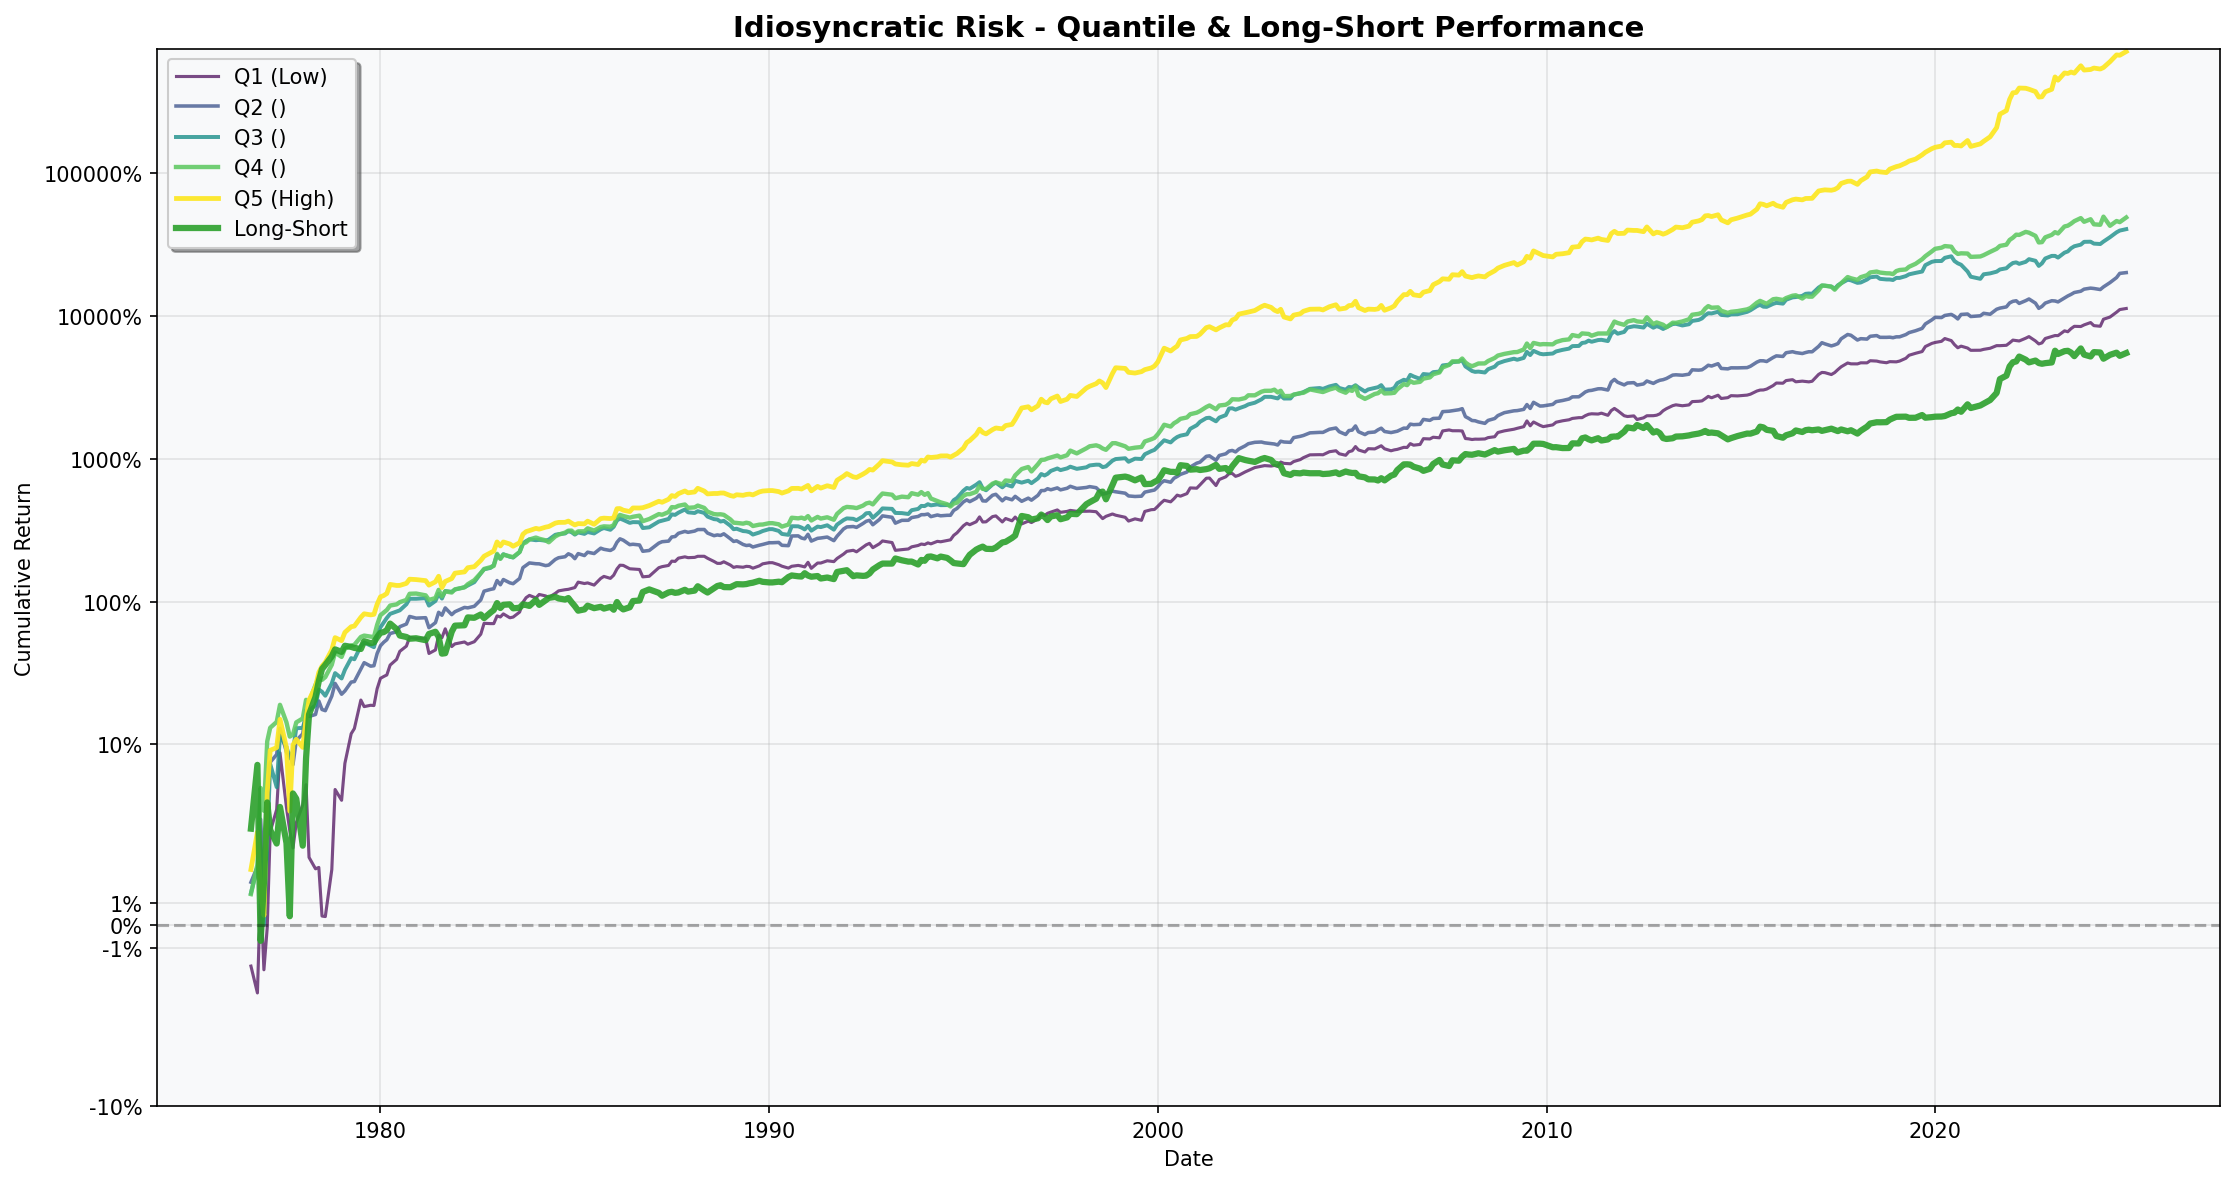

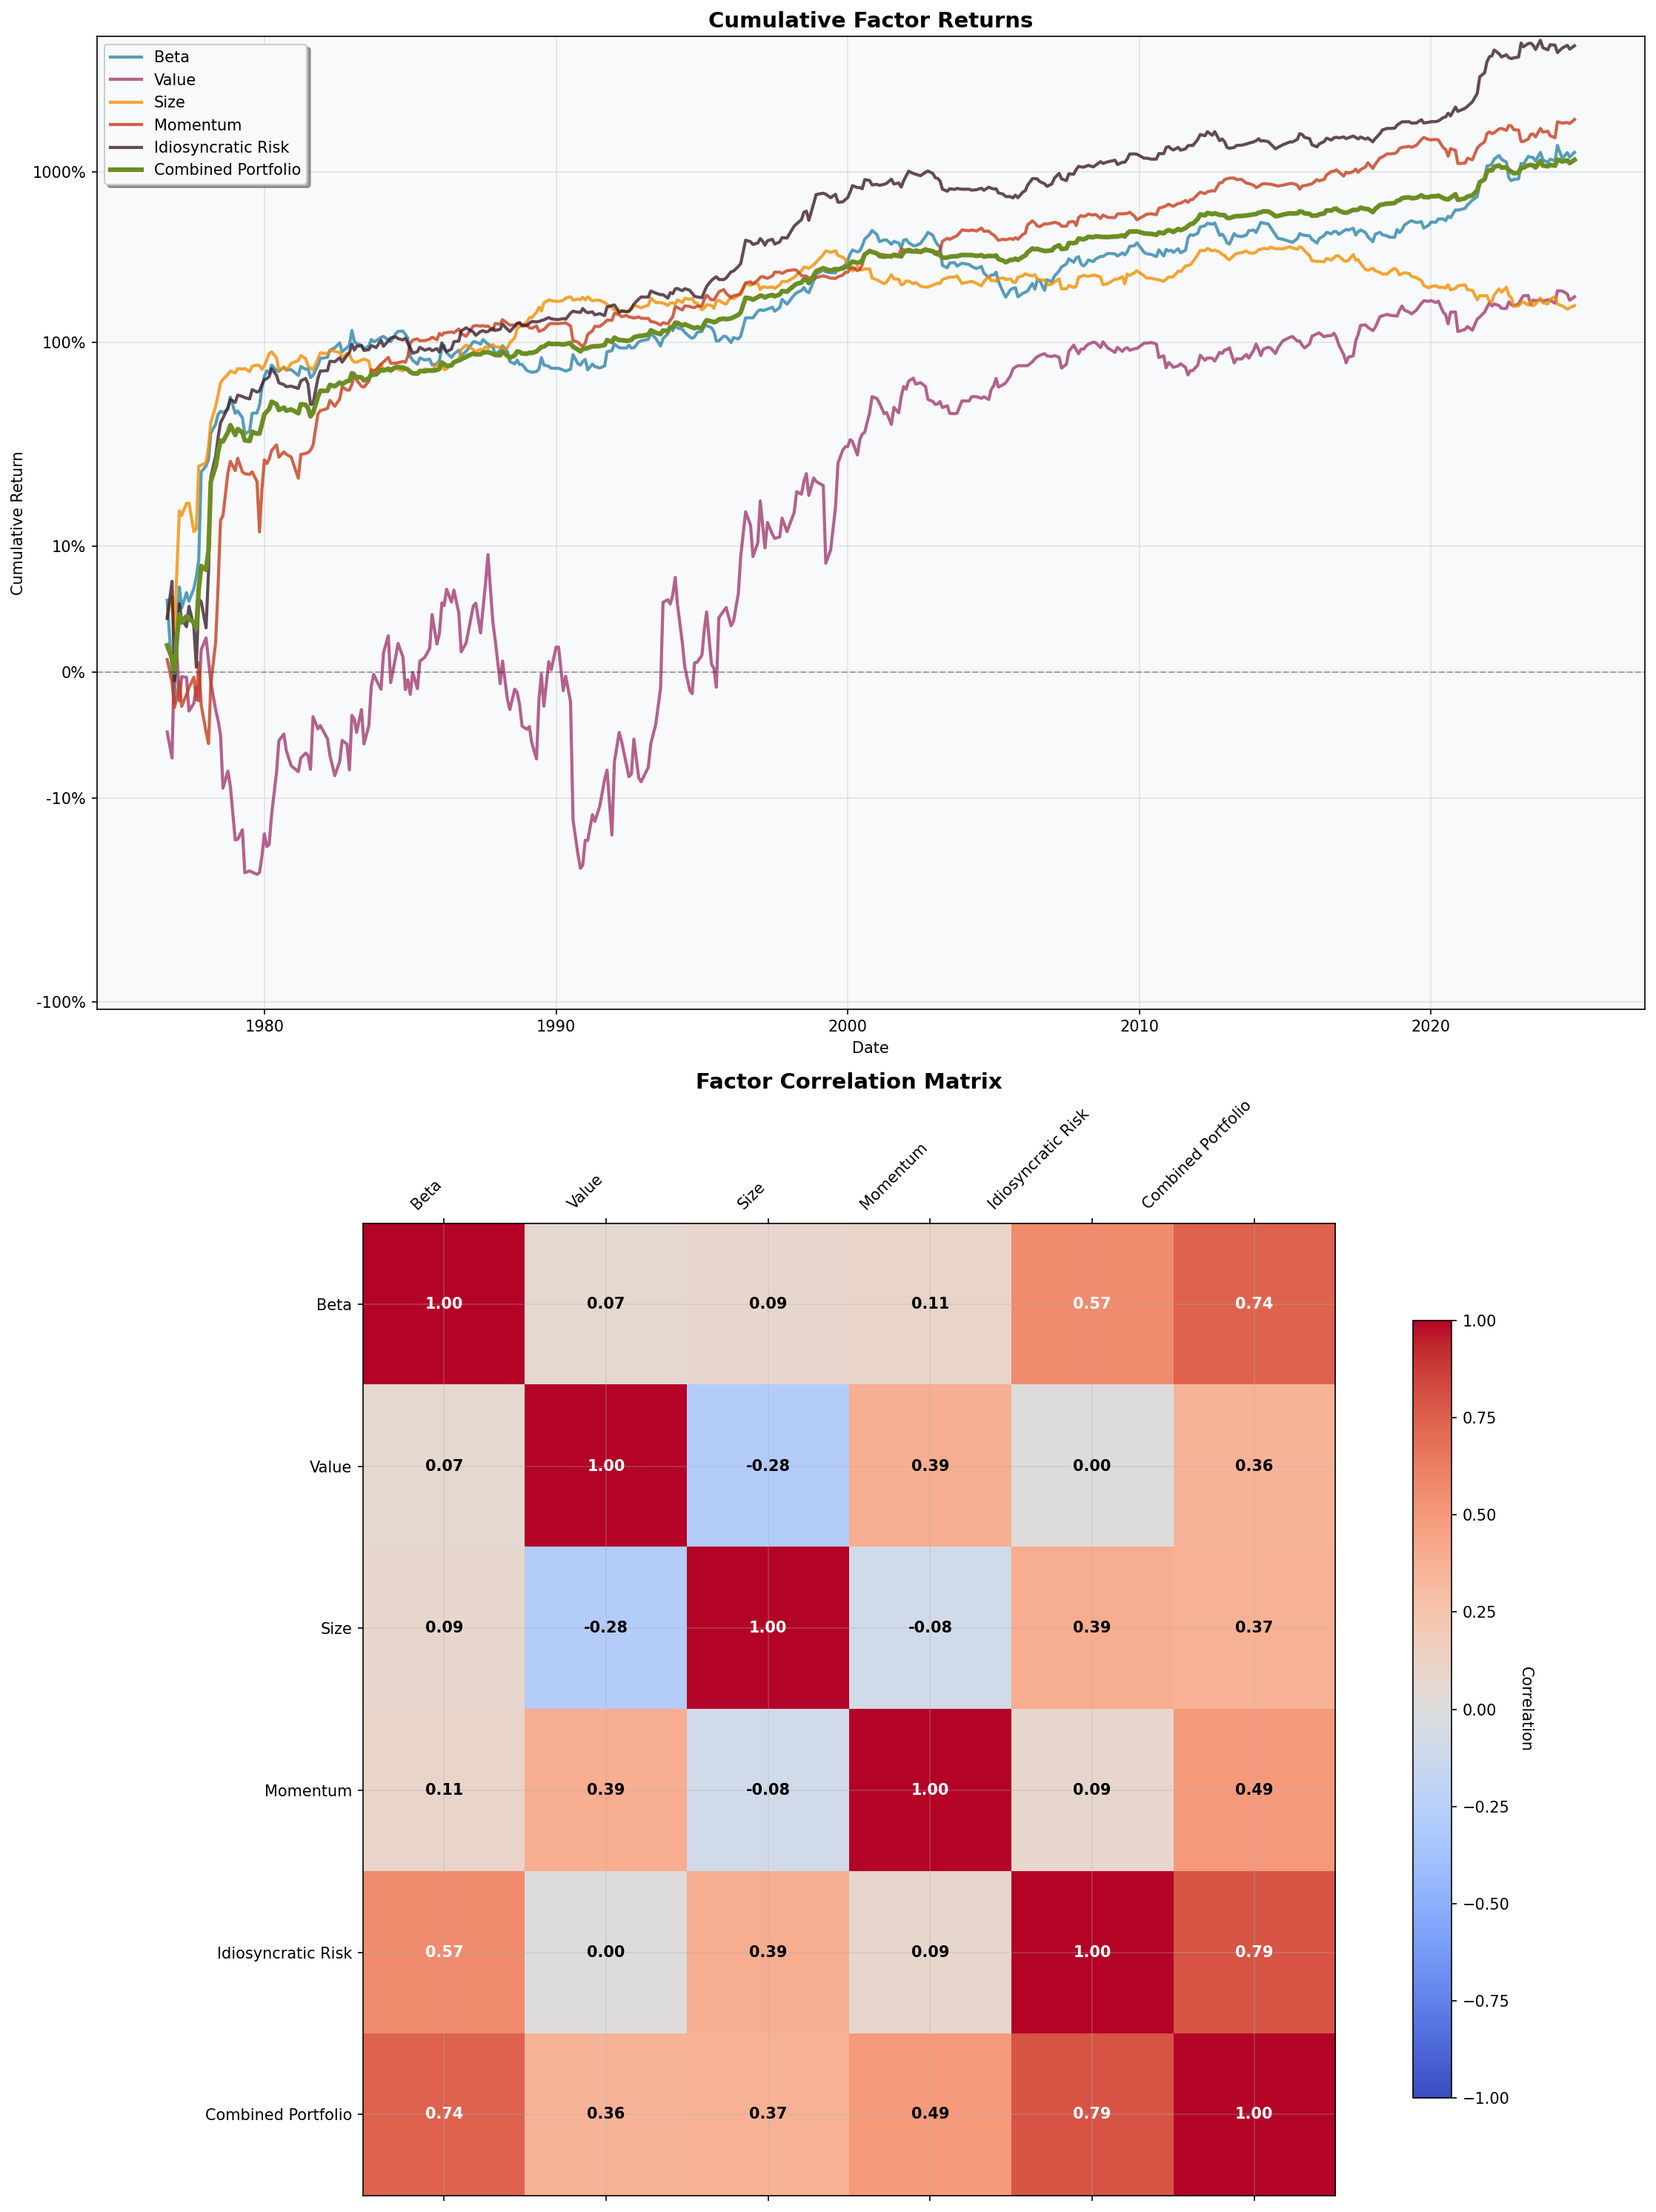

In [52]:
def carthart4_backtest_vw():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['beta', 'value', 'size', 'momentum', 'idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='vw')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='vw')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

carthart4_backtest_vw()


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      7.4%       11.5%     0.273     3.20%       0.277
value                     5.5%        7.0%     0.177     1.07%       0.151
size                      3.5%        9.6%    -0.077    -0.57%      -0.059
momentum                 11.7%        7.7%     0.961     7.61%       0.978
idiosyncratic_risk       10.3%        9.8%     0.614     6.15%       0.626
combined_portfolio        7.6%        5.4%     0.633     3.49%       0.639

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             15.5%        9.6%     1.172
Q2             16.4%       10.9%     1.120
Q3             18.2%       11.6%     1.205
Q4             20.8%       12.2%     1.353
Q5             25.8%       1

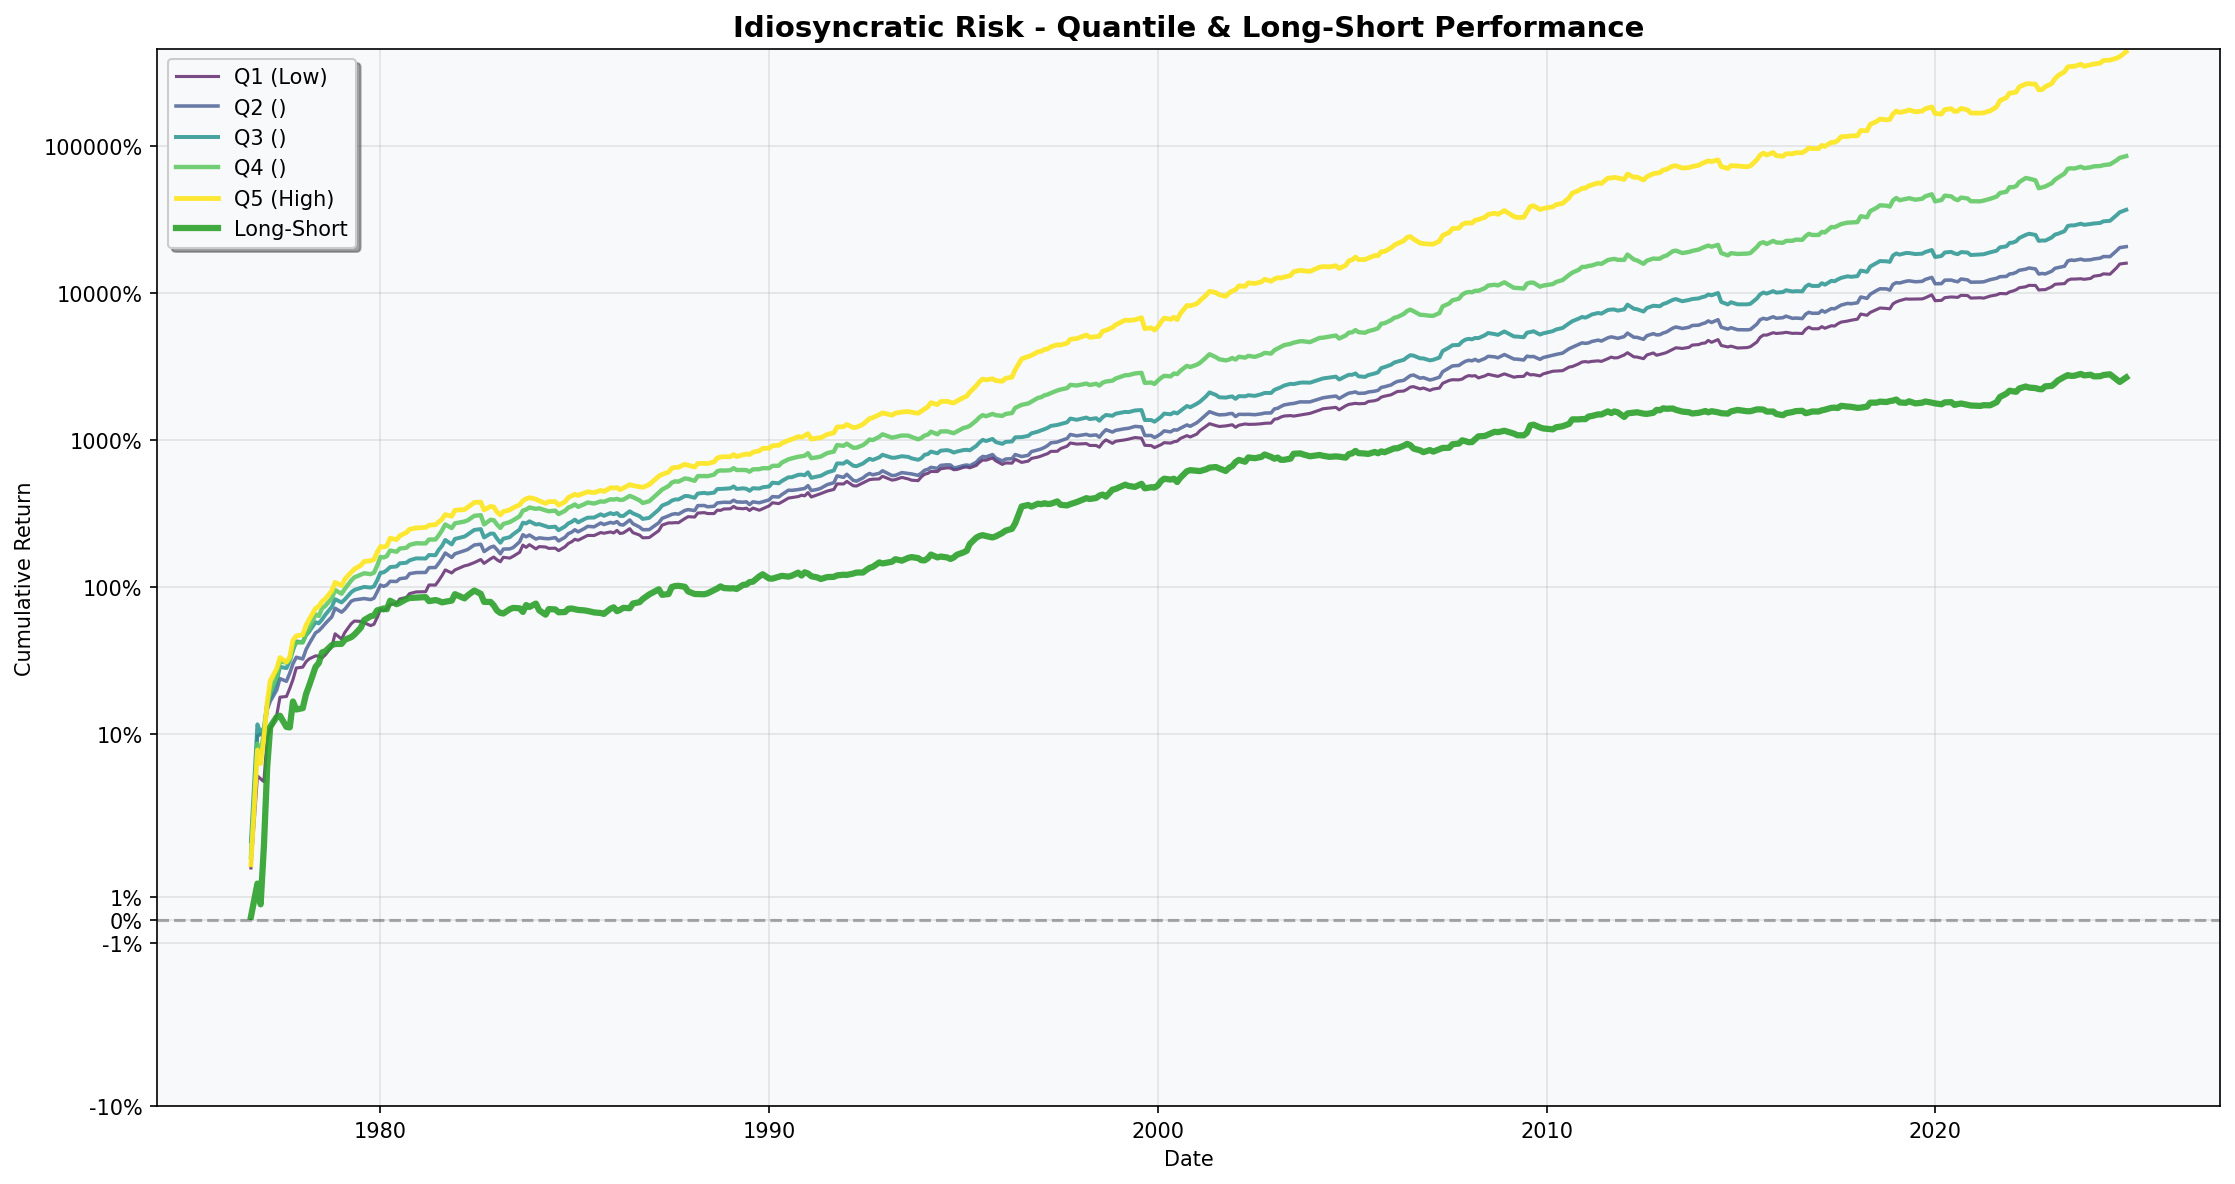

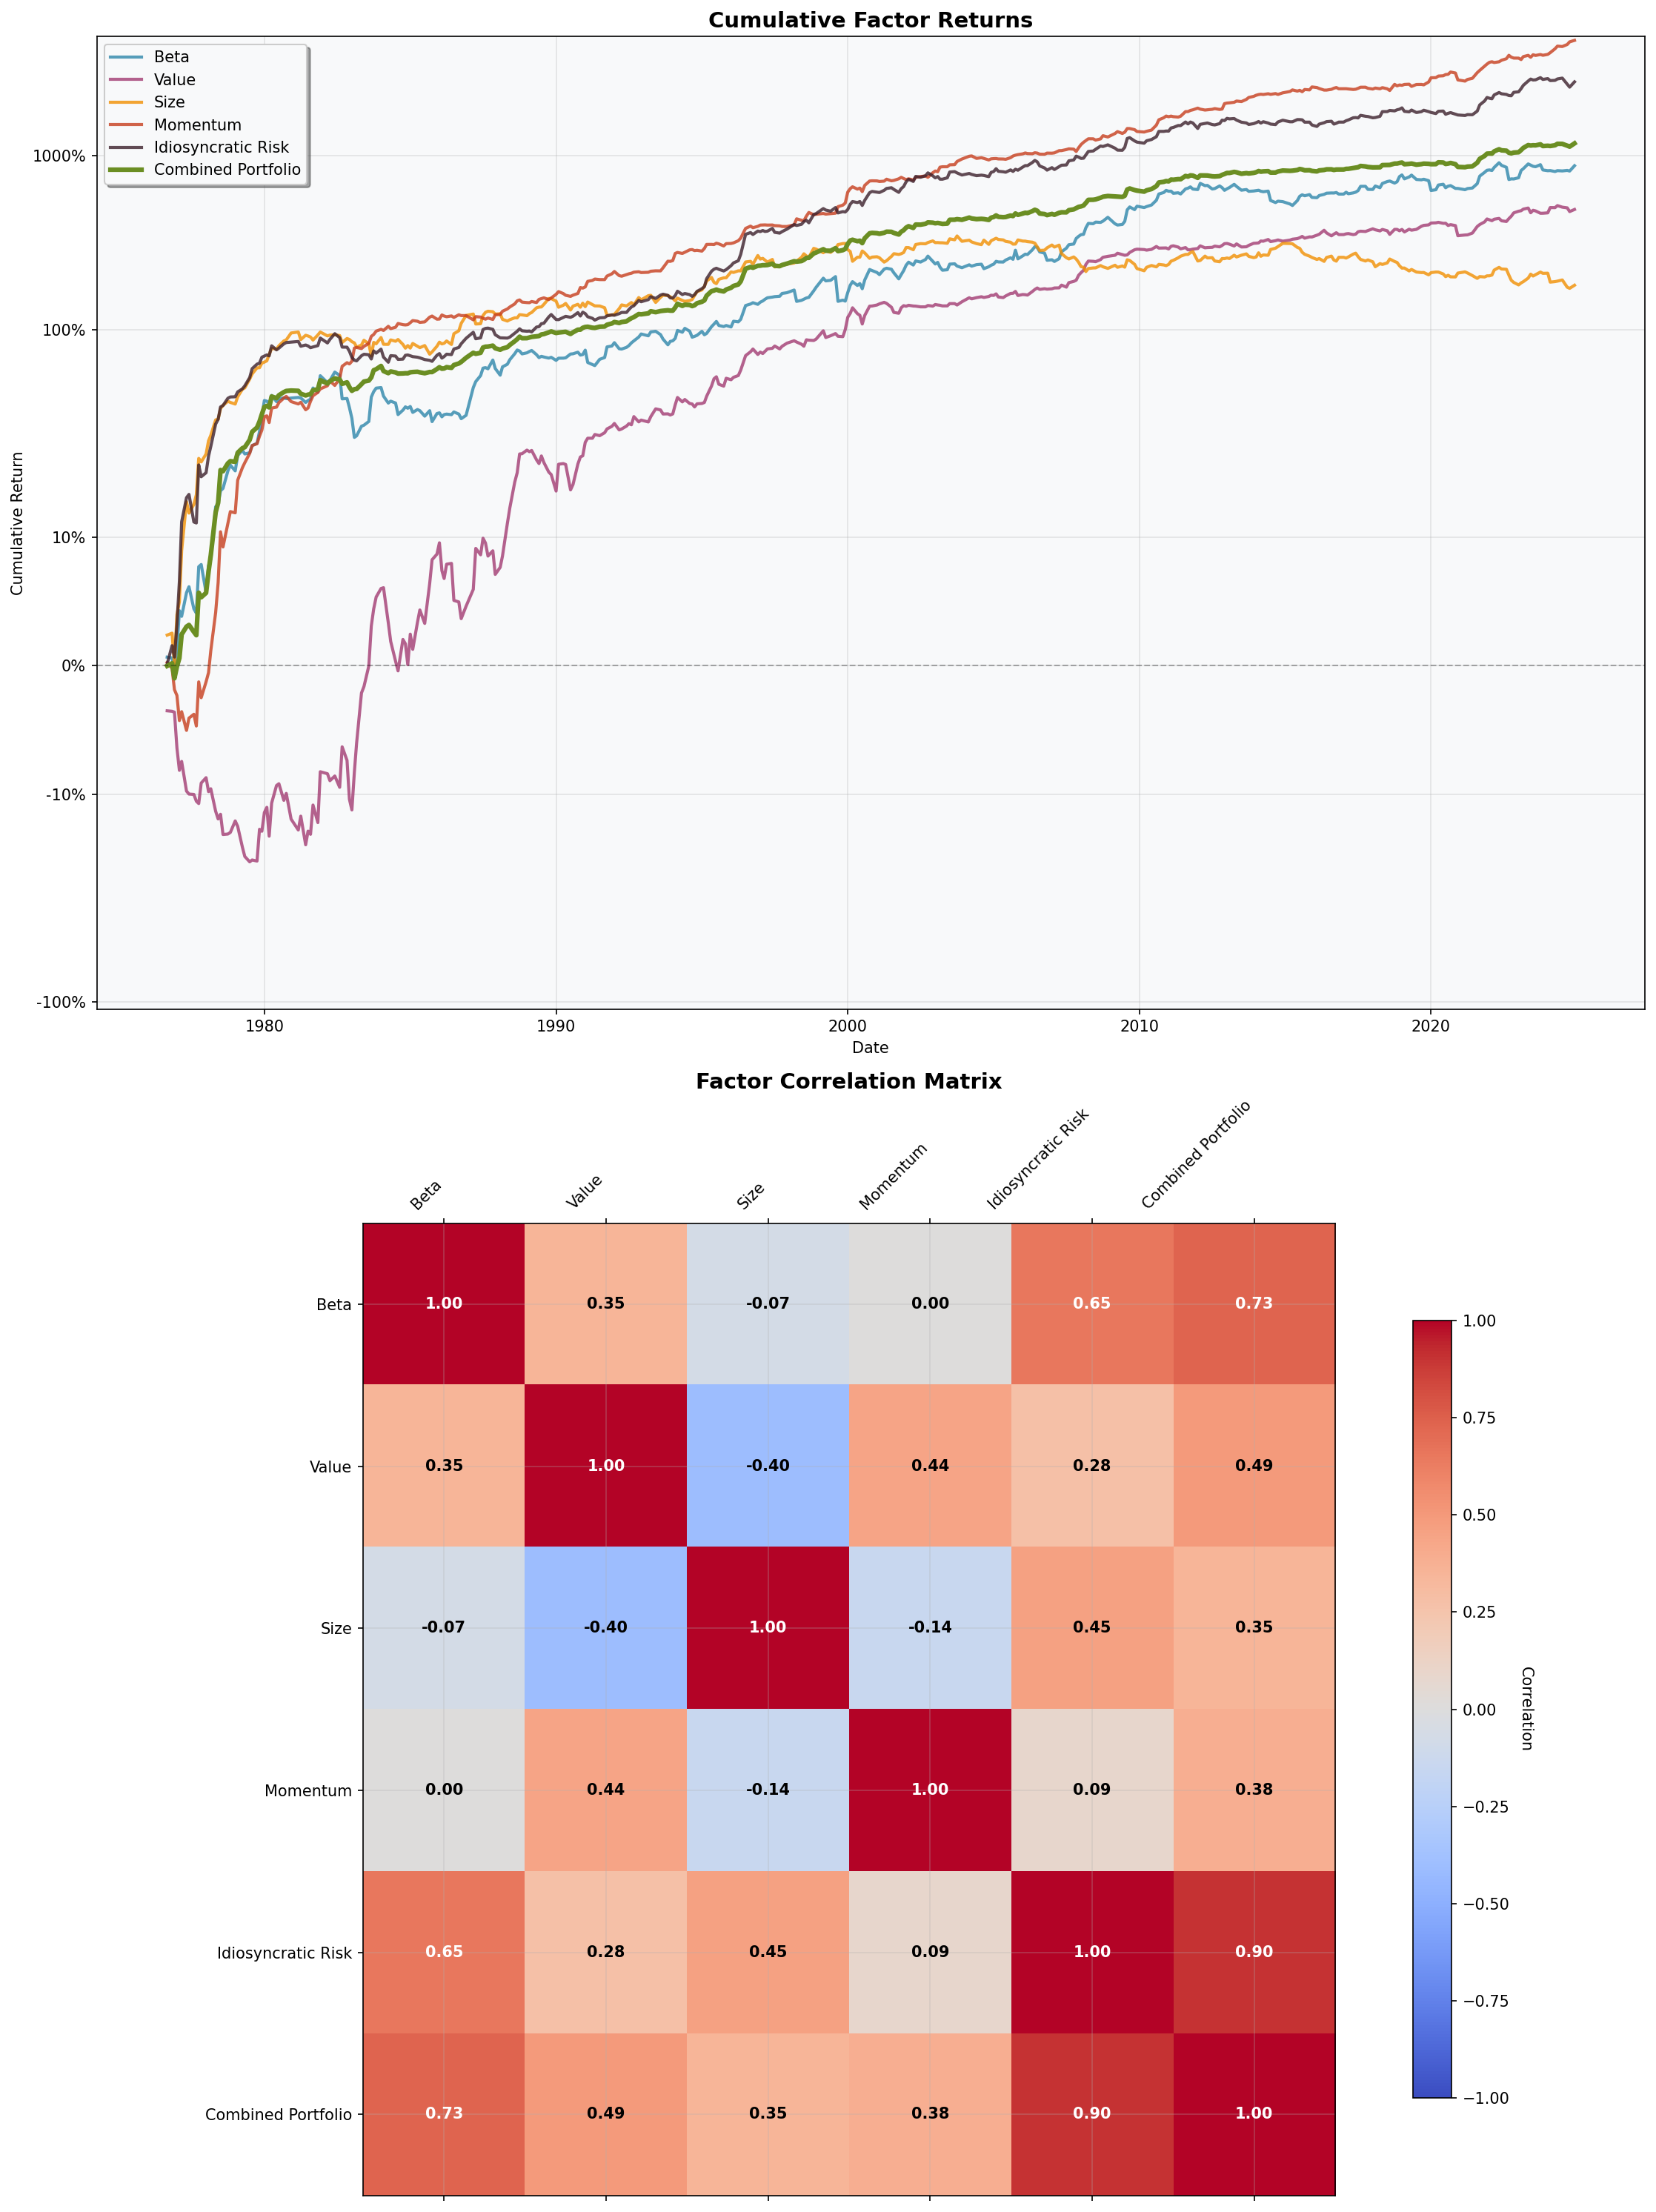

In [53]:
def carthart4_backtest_ew():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['beta', 'value', 'size', 'momentum', 'idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='ew')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='ew')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

carthart4_backtest_ew()

##### CAPM + Idiosync. Risk - Value & Equal-weighted


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      8.6%       16.7%     0.264     4.66%       0.279
idiosyncratic_risk       13.3%       15.8%     0.574     9.00%       0.568
combined_portfolio       11.0%       14.7%     0.459     6.83%       0.464

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             14.7%       12.2%     0.855
Q2             15.7%       12.8%     0.894
Q3             17.9%       13.8%     0.989
Q4             20.5%       14.8%     1.099
Q5             28.0%       18.2%     1.305
L/S            13.3%       15.8%     0.574


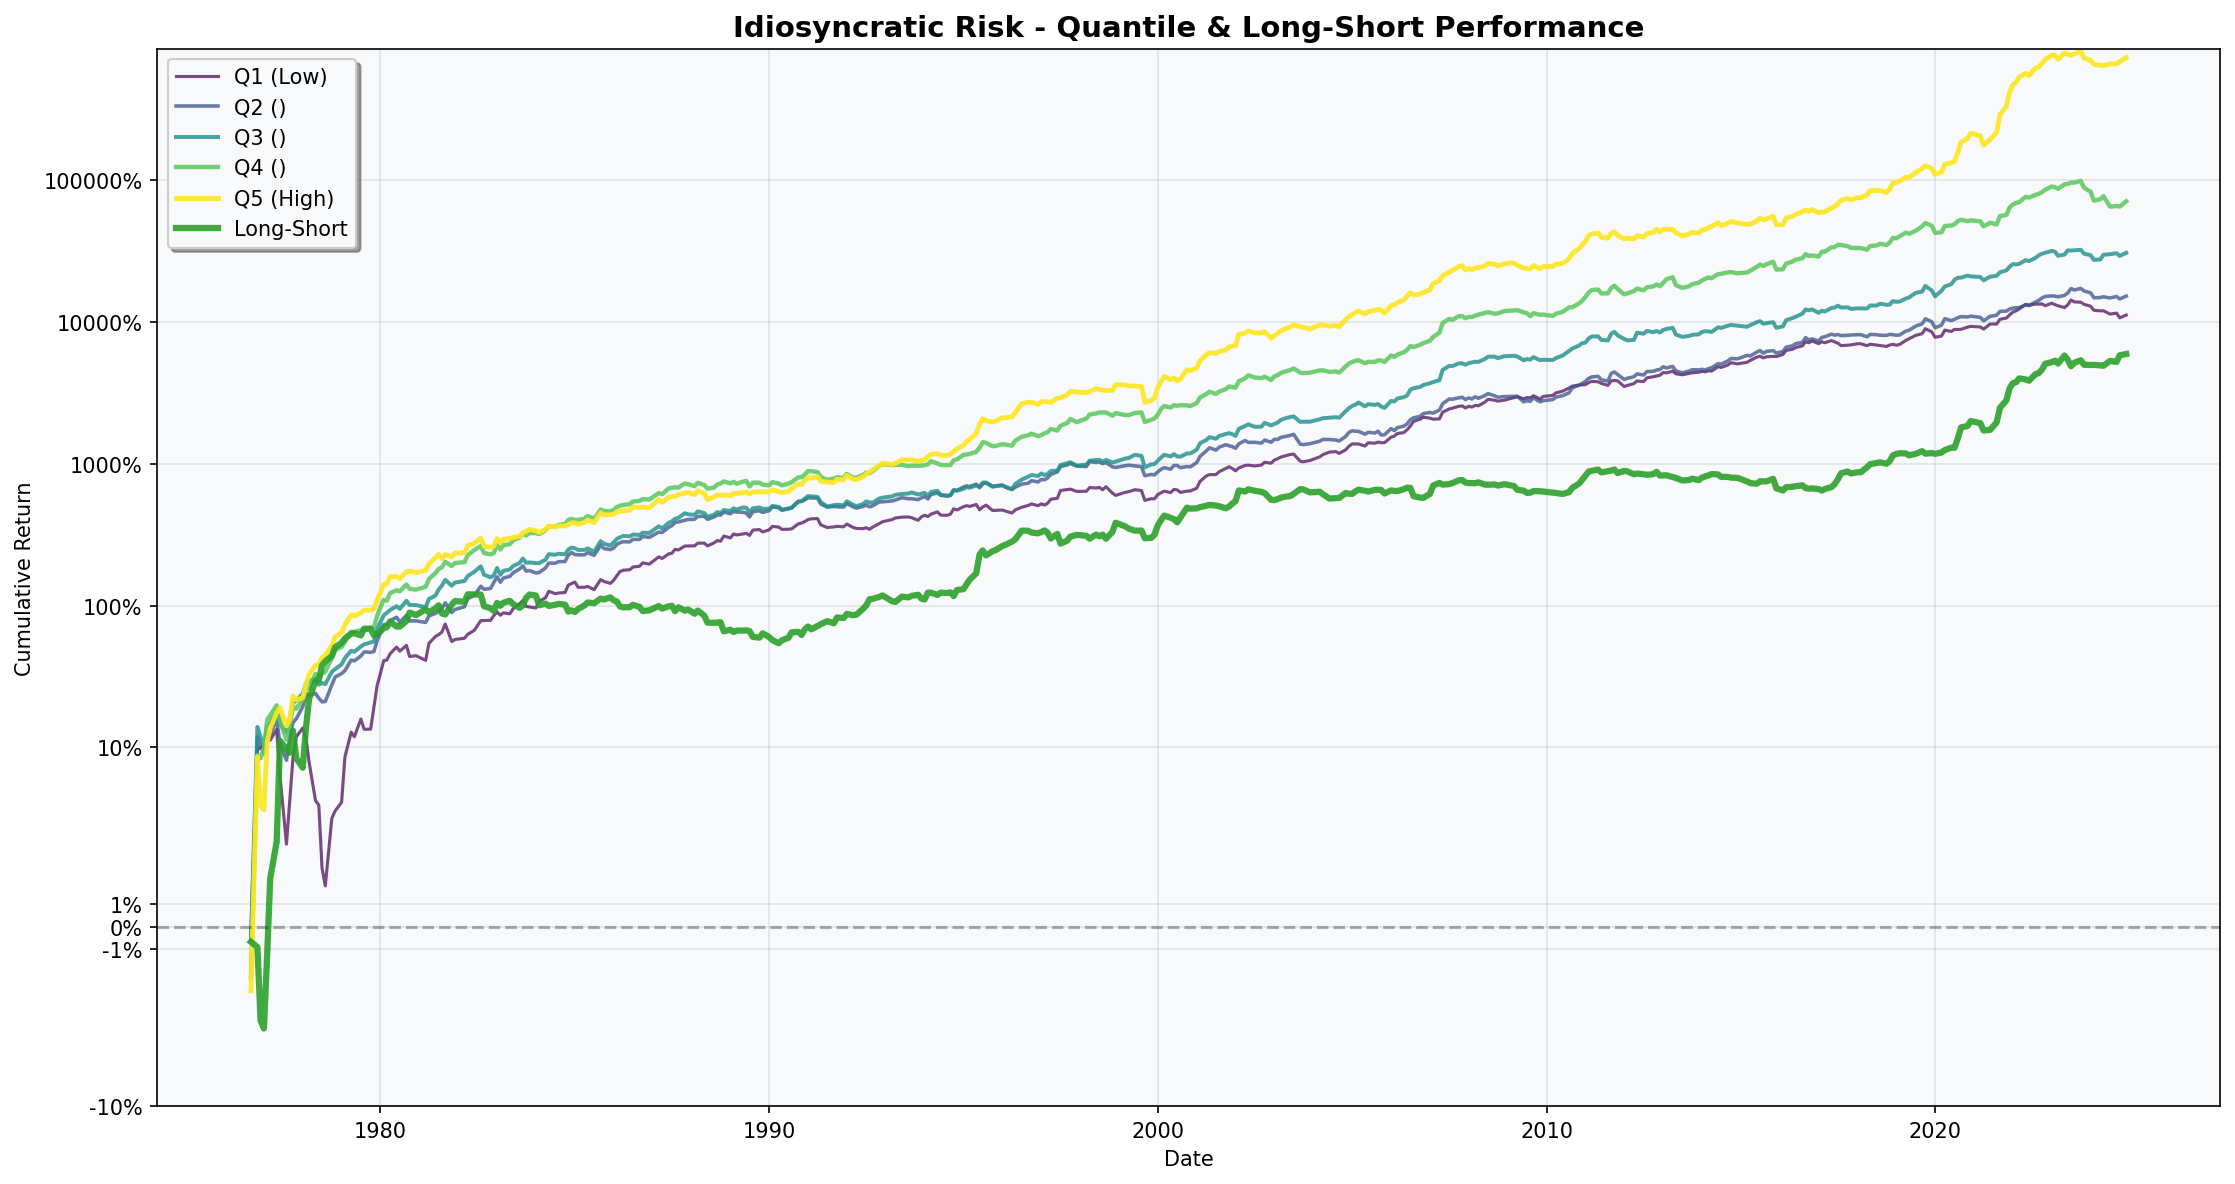

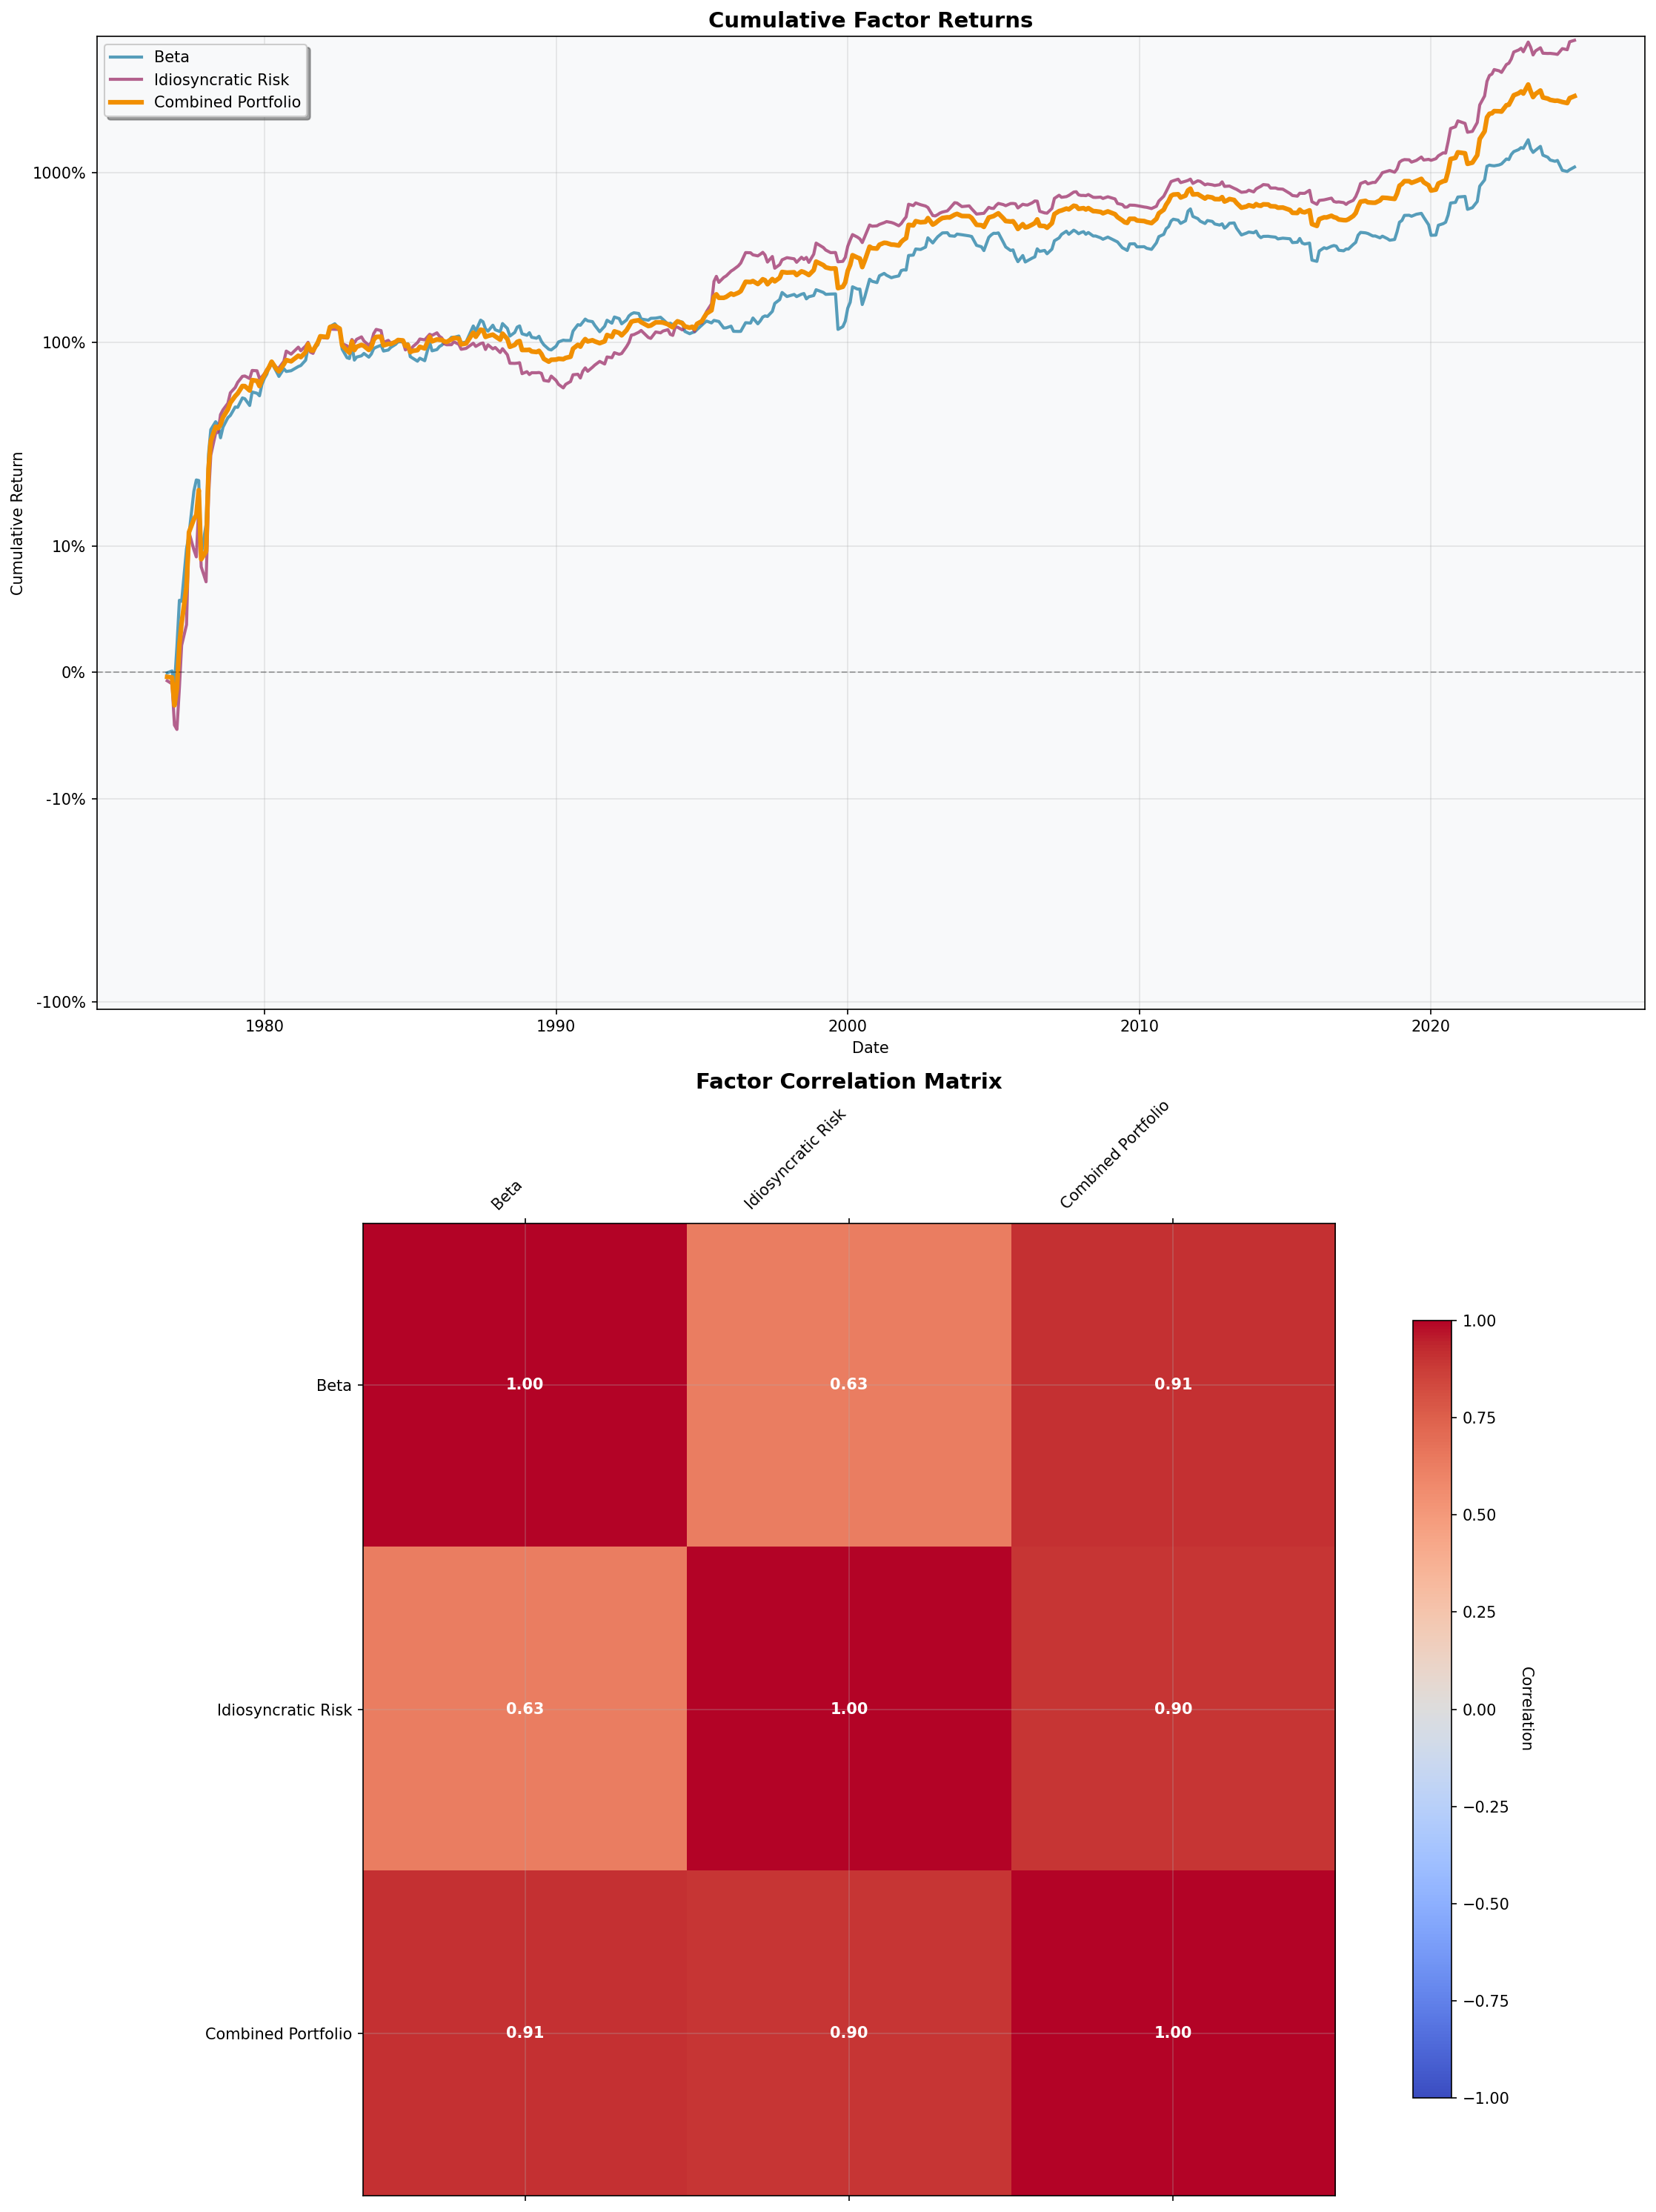

In [54]:
def capm_backtest_vw():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['beta', 'idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='vw')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='vw')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

capm_backtest_vw()


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      7.4%       12.1%     0.265     3.51%       0.290
idiosyncratic_risk       11.3%        9.6%     0.735     6.97%       0.723
combined_portfolio        9.4%        9.9%     0.518     5.24%       0.527

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             14.6%        9.4%     1.103
Q2             15.8%       10.5%     1.107
Q3             17.7%       11.3%     1.193
Q4             20.2%       11.9%     1.340
Q5             25.9%       13.0%     1.667
L/S            11.3%        9.6%     0.735


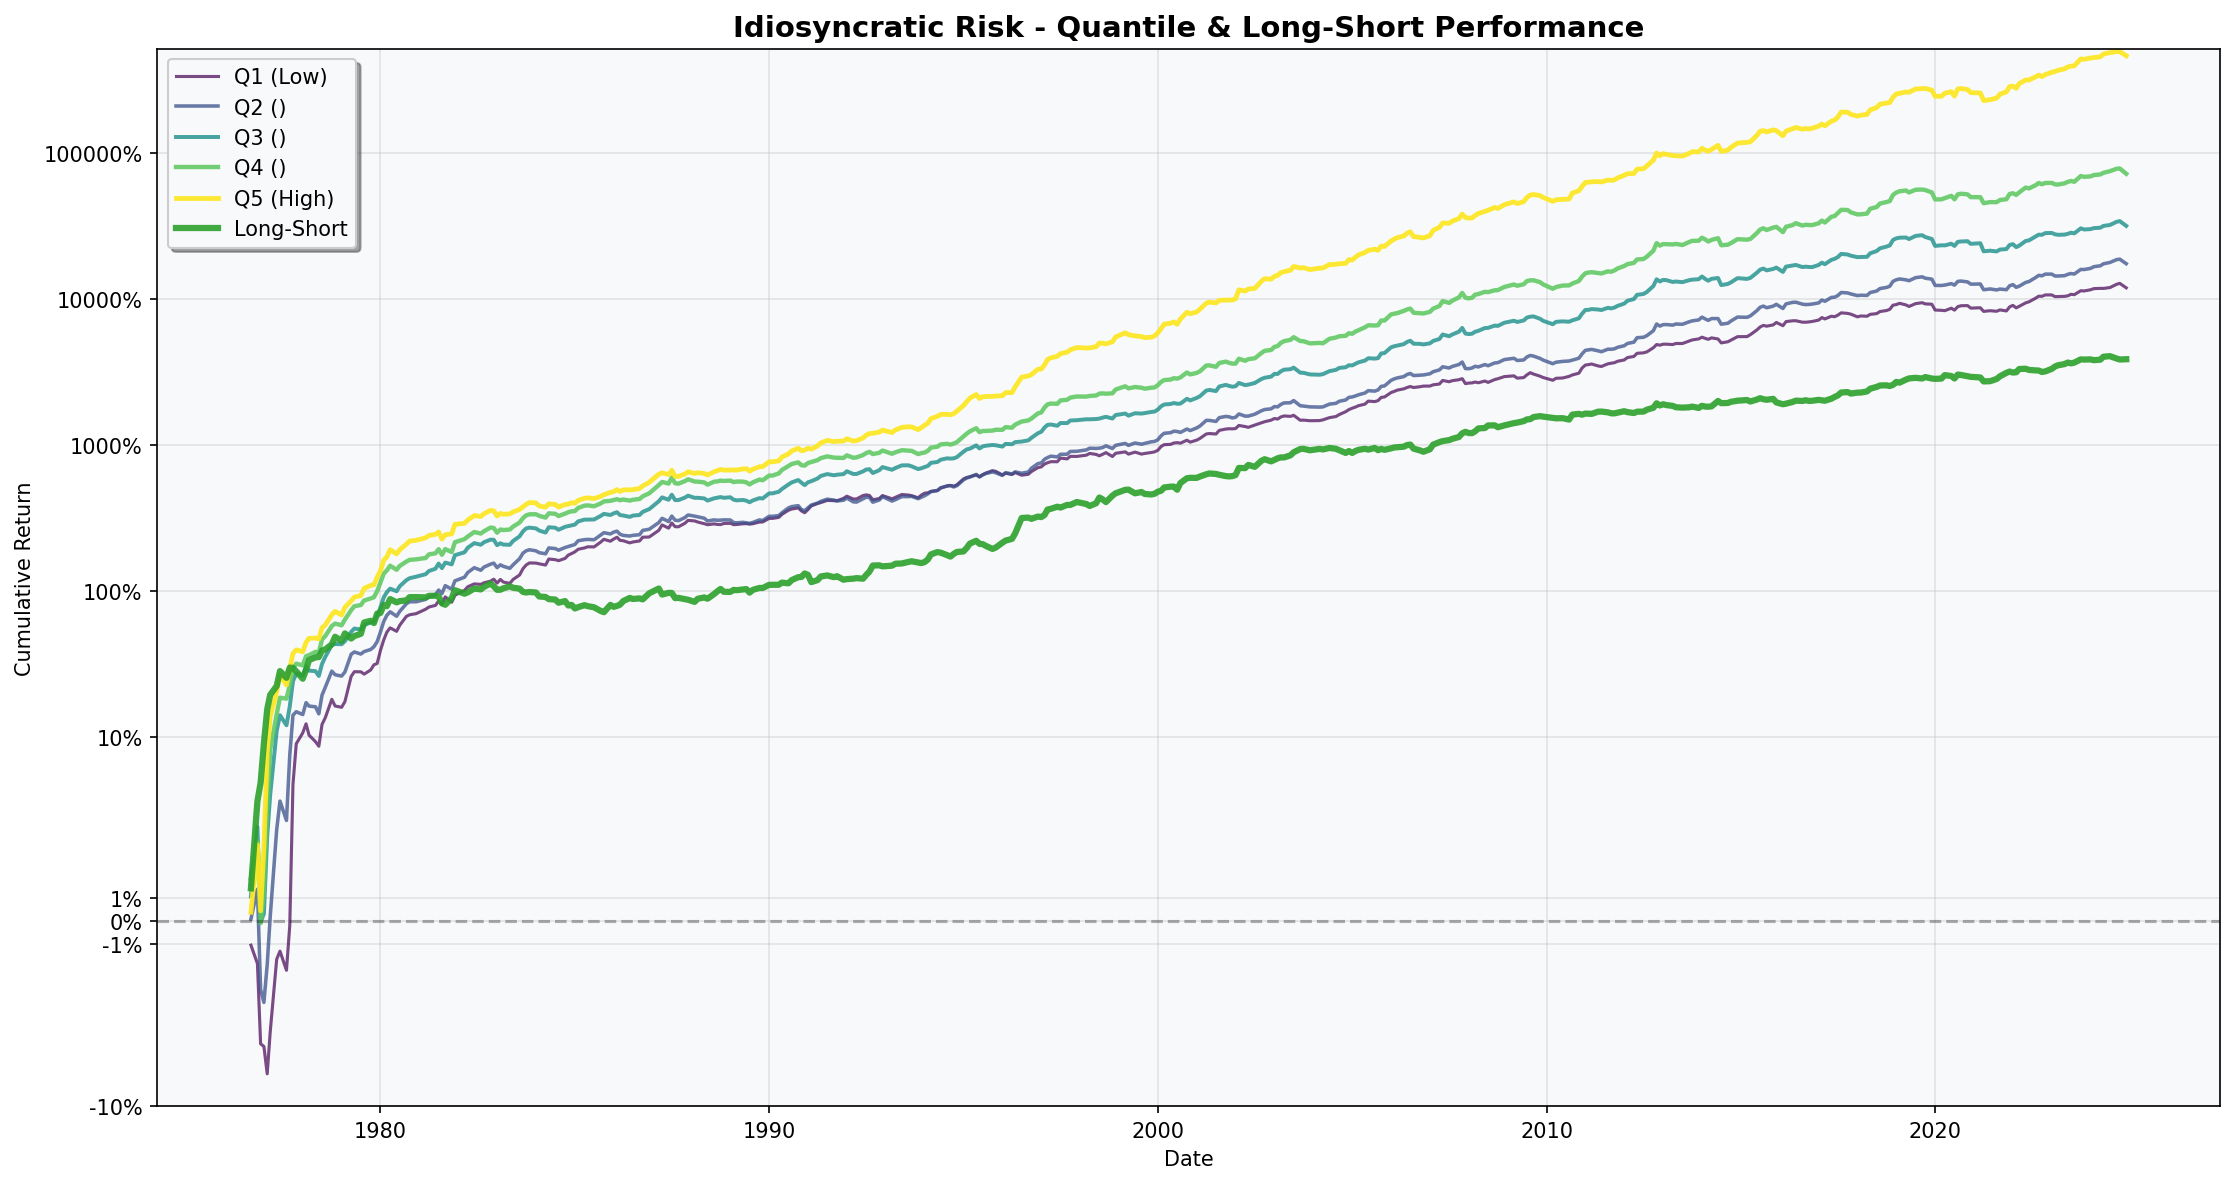

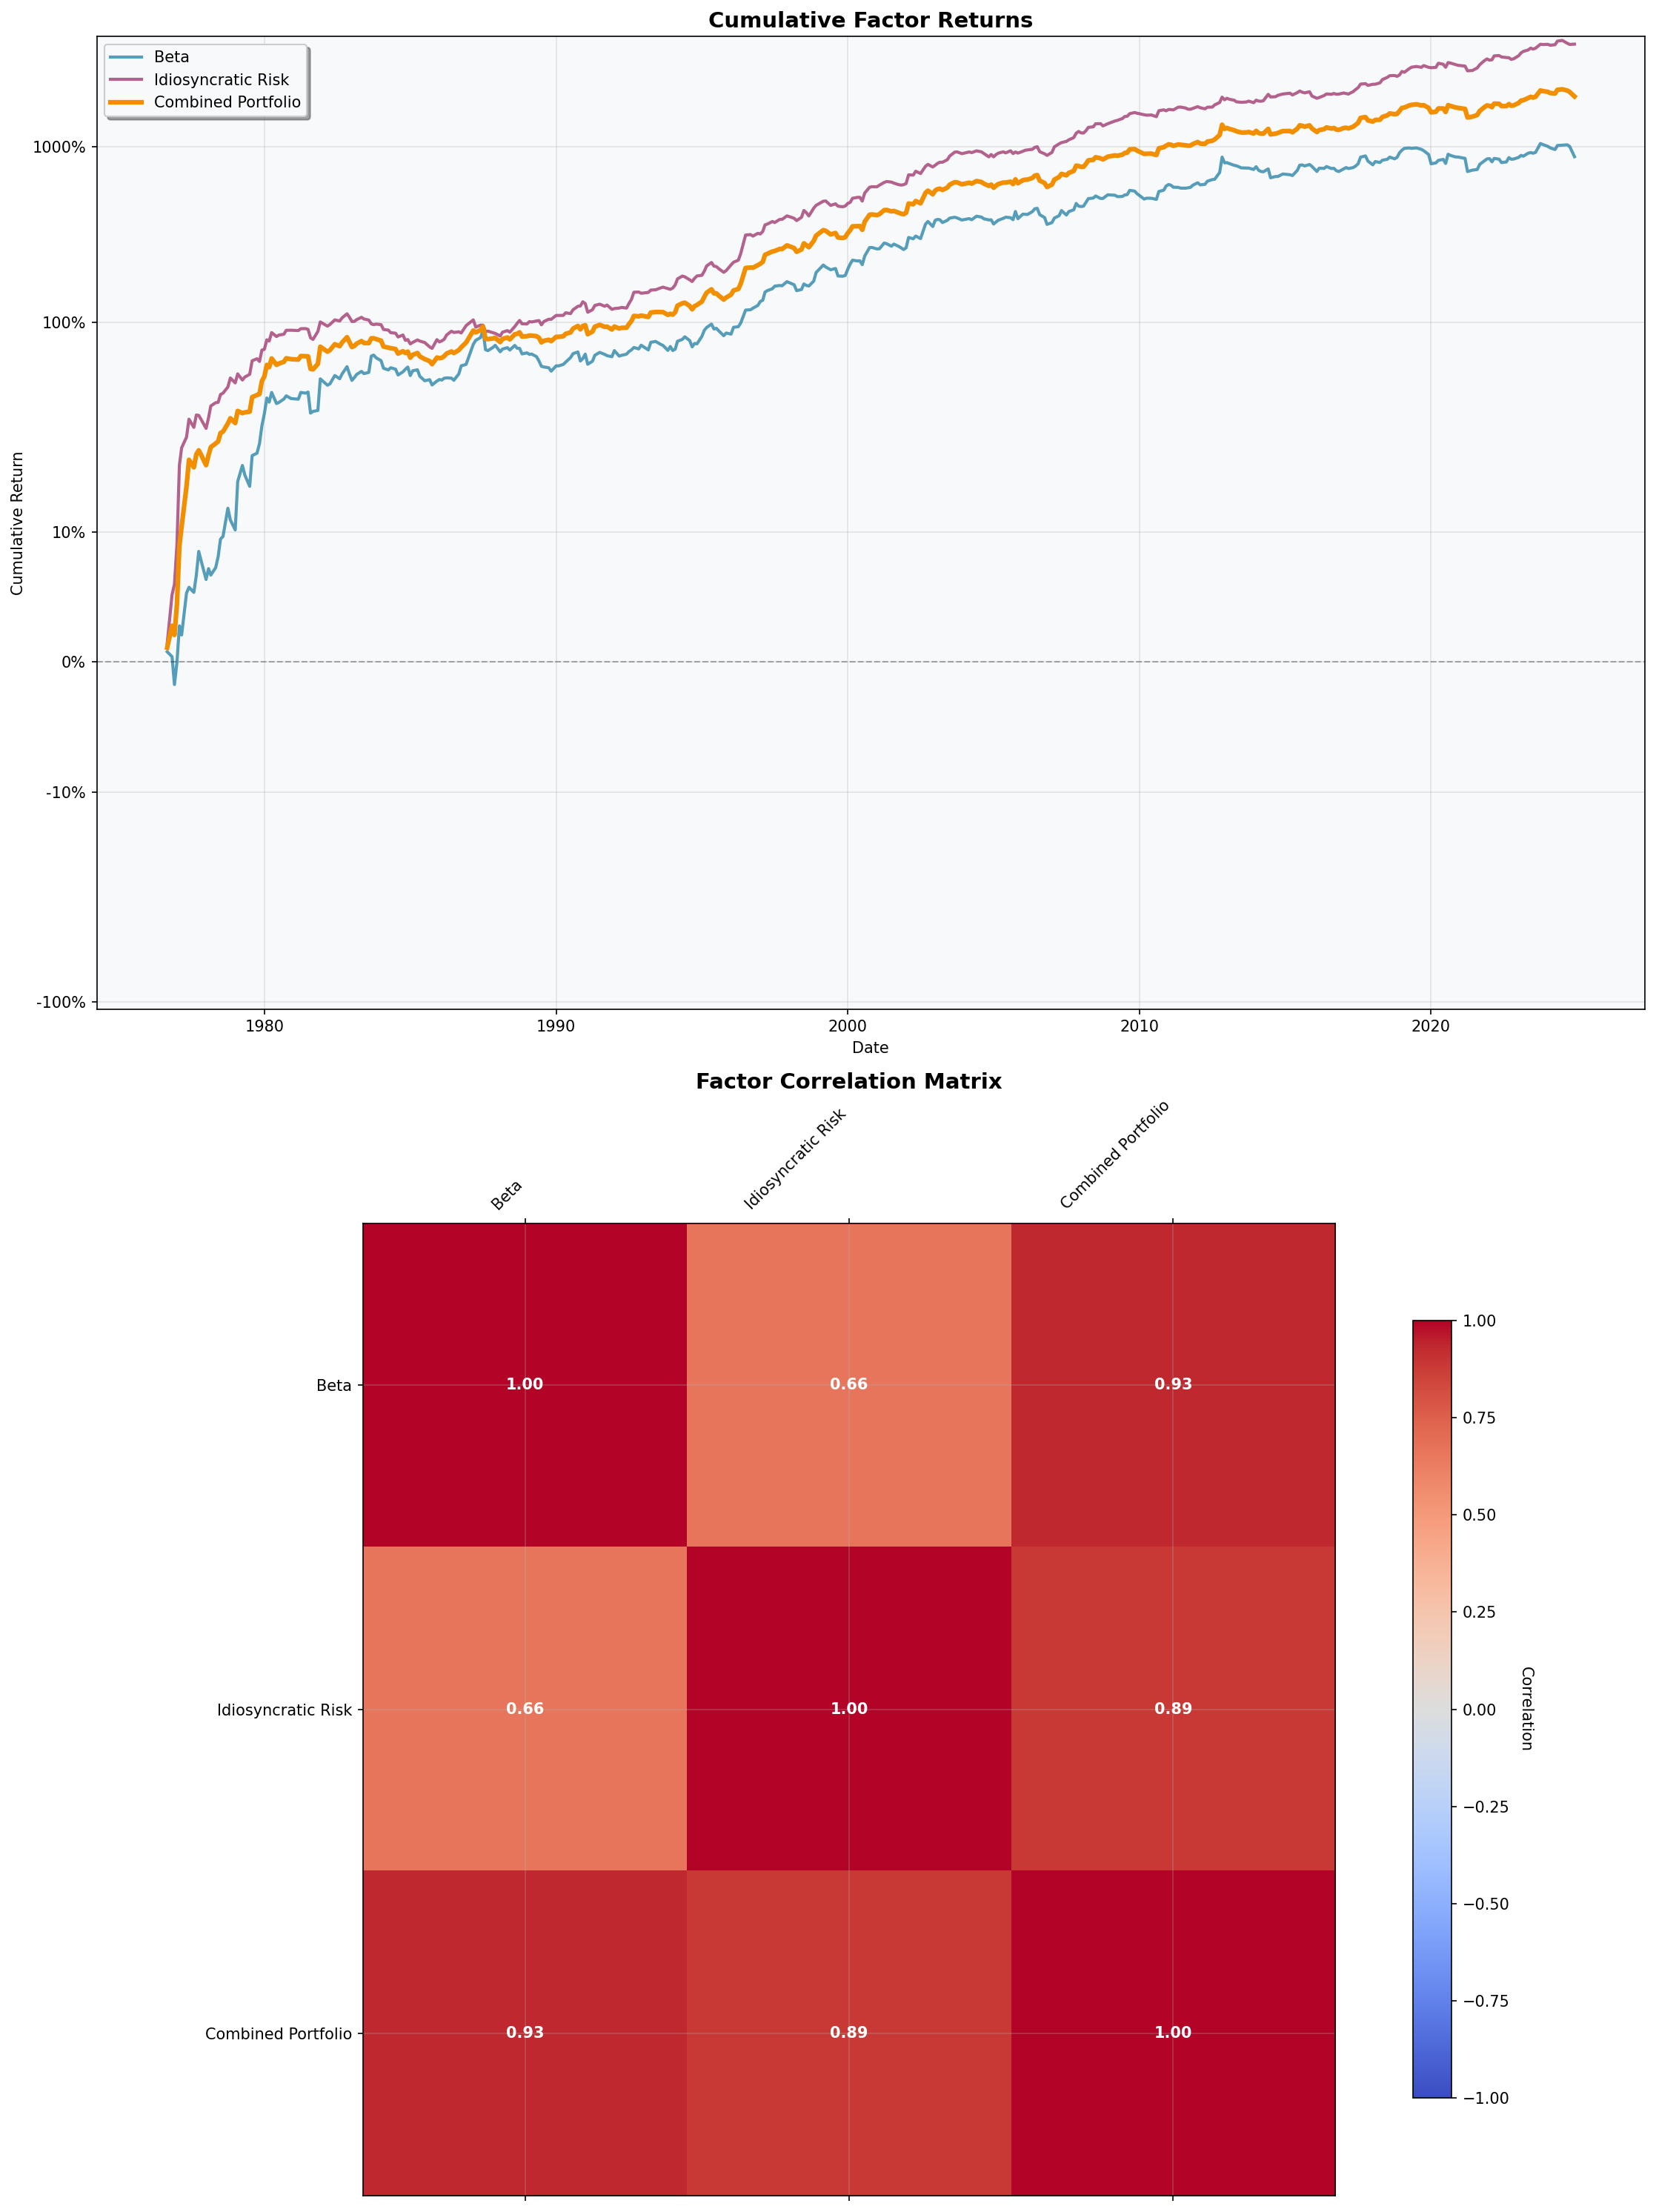

In [55]:
def capm_backtest_ew():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['beta', 'idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='ew')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='ew')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

capm_backtest_ew()

##### Idiosync. Risk Alone - Value & Equal-weighted


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
idiosyncratic_risk       13.4%       14.6%     0.626     9.38%       0.642
combined_portfolio       13.4%       14.6%     0.626     9.38%       0.642

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             13.8%       11.7%     0.812
Q2             15.6%       12.8%     0.885
Q3             19.5%       13.5%     1.138
Q4             19.8%       15.5%     1.000
Q5             27.2%       17.0%     1.346
L/S            13.4%       14.6%     0.626


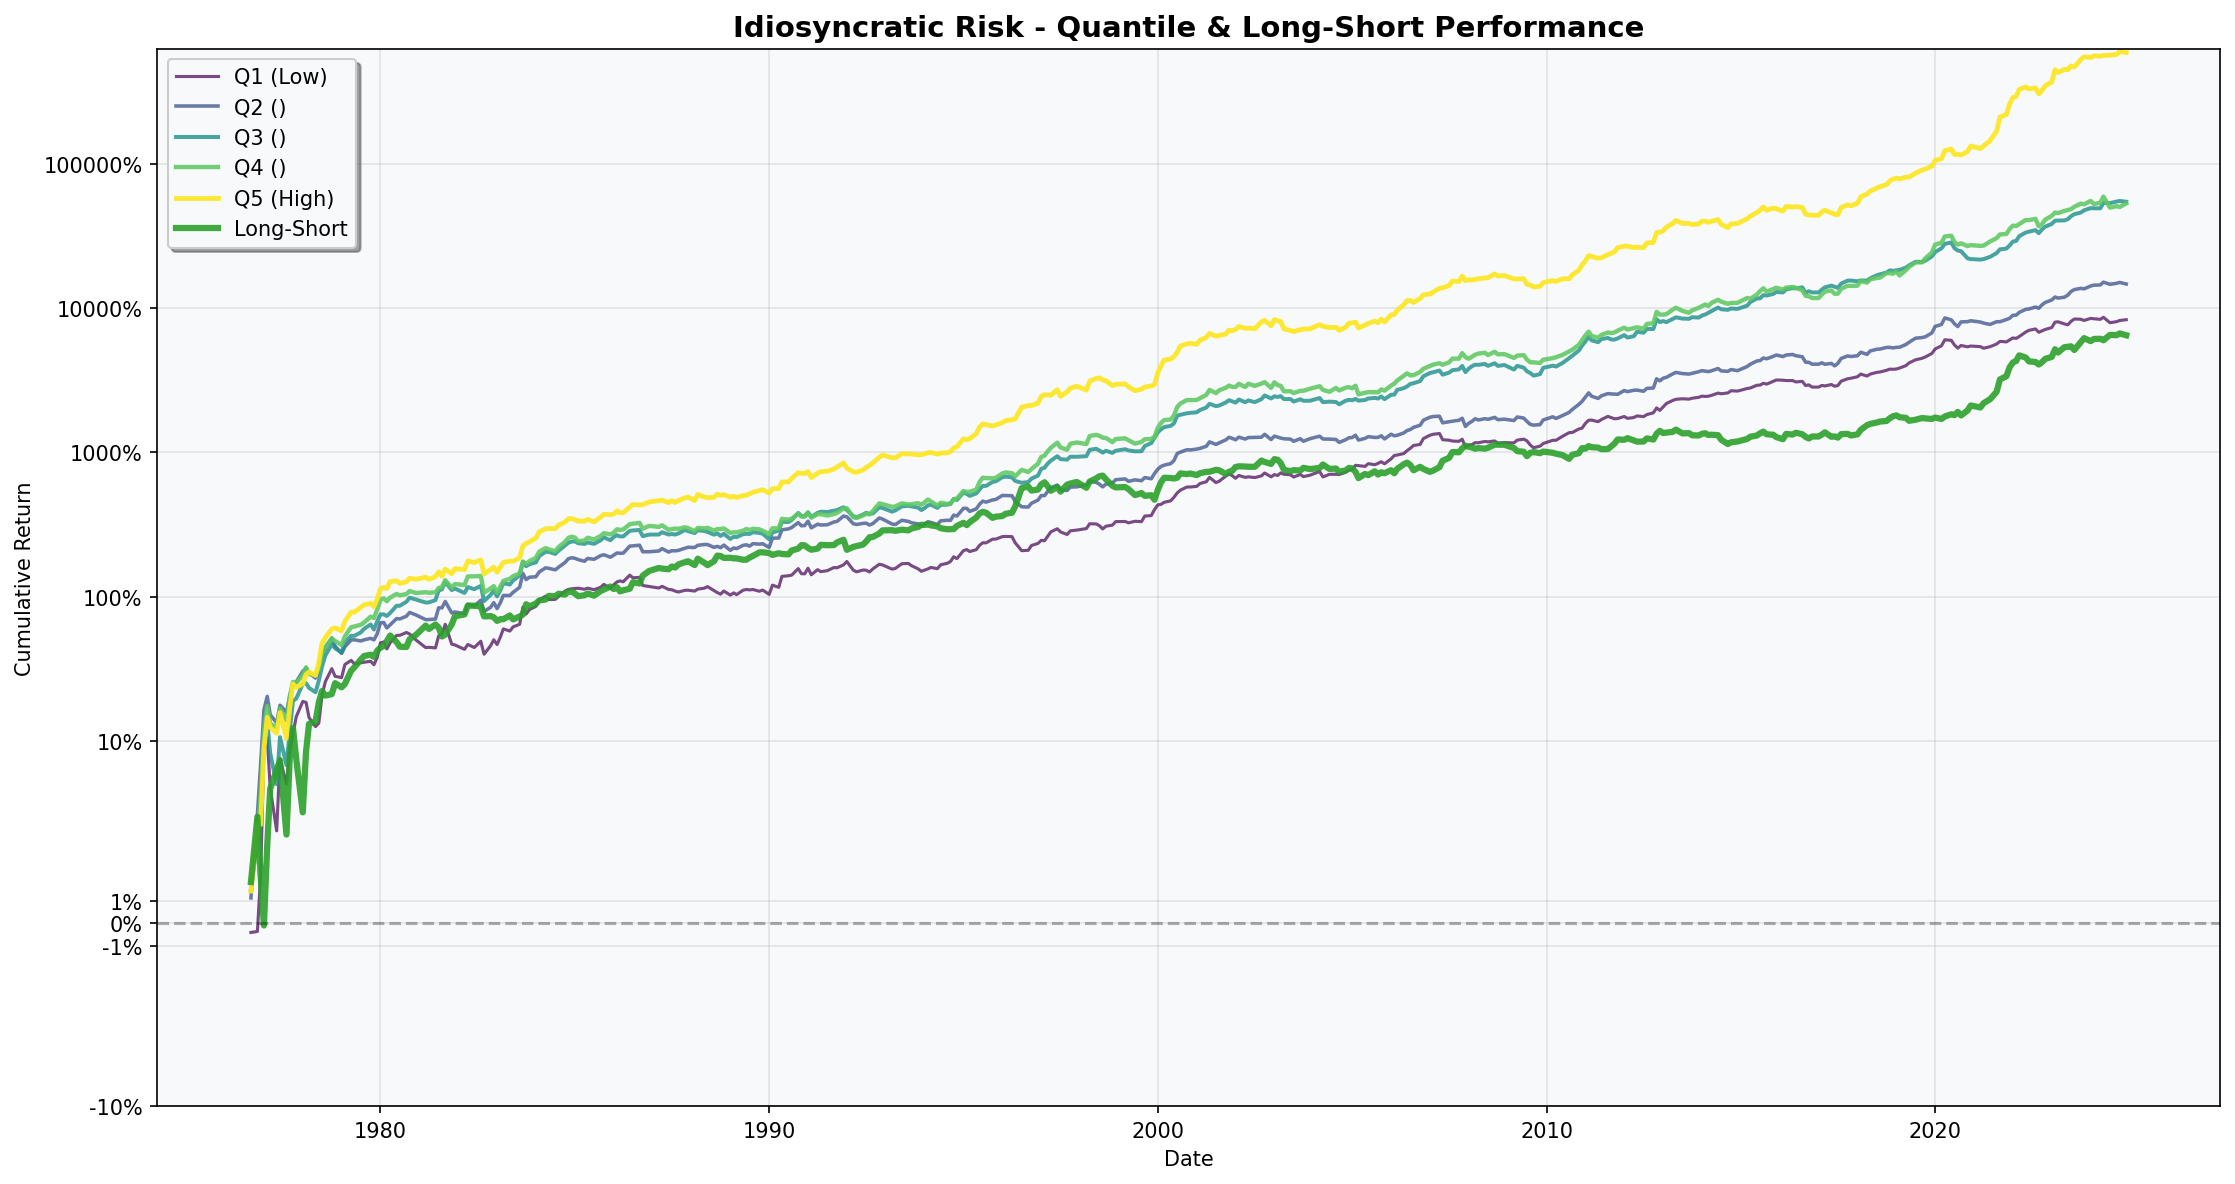

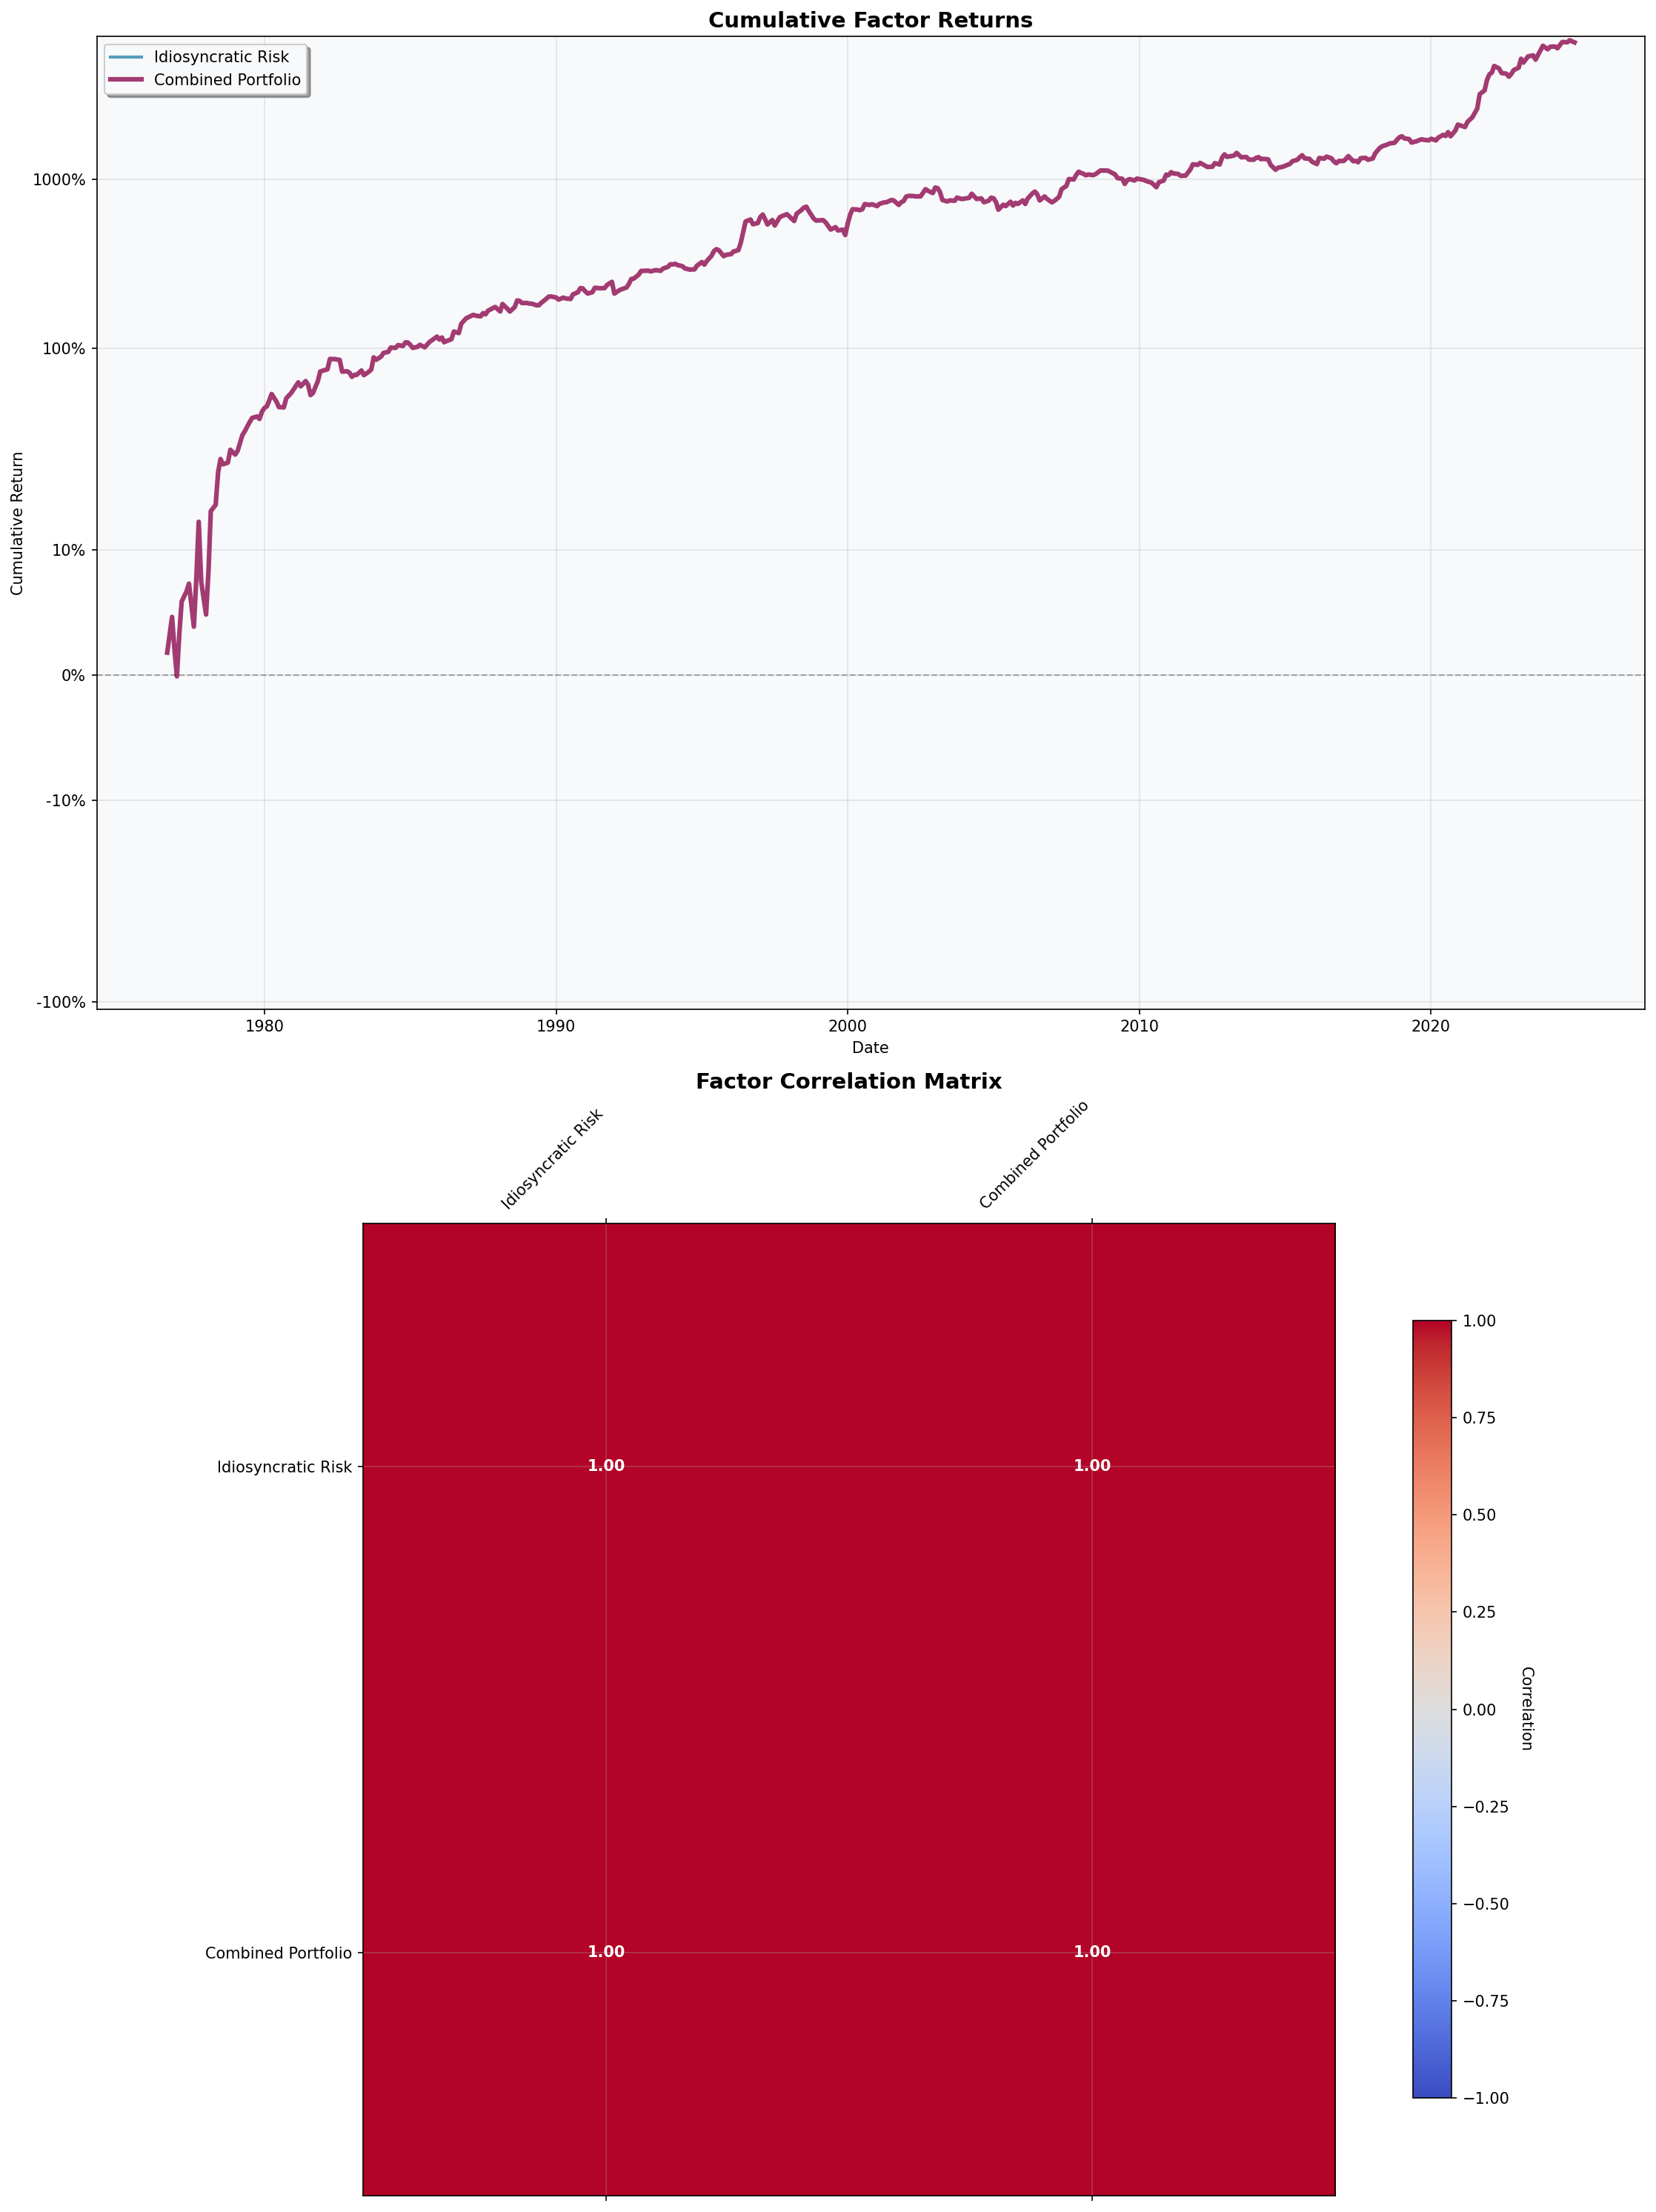

In [56]:
def ir_backtest_vw():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='vw')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='vw')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

ir_backtest_vw()


PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
idiosyncratic_risk       11.7%       15.3%     0.491     7.51%       0.492
combined_portfolio       11.7%       15.3%     0.491     7.51%       0.492

Idiosyncratic Risk - Quantile Performance Summary
Quantile       Return   Volatility     Sharpe
------------------------------------------------------------
Q1             14.5%       12.0%     0.855
Q2             14.7%       12.7%     0.823
Q3             18.3%       14.0%     1.010
Q4             19.8%       15.4%     1.012
Q5             26.2%       17.8%     1.235
L/S            11.7%       15.3%     0.491


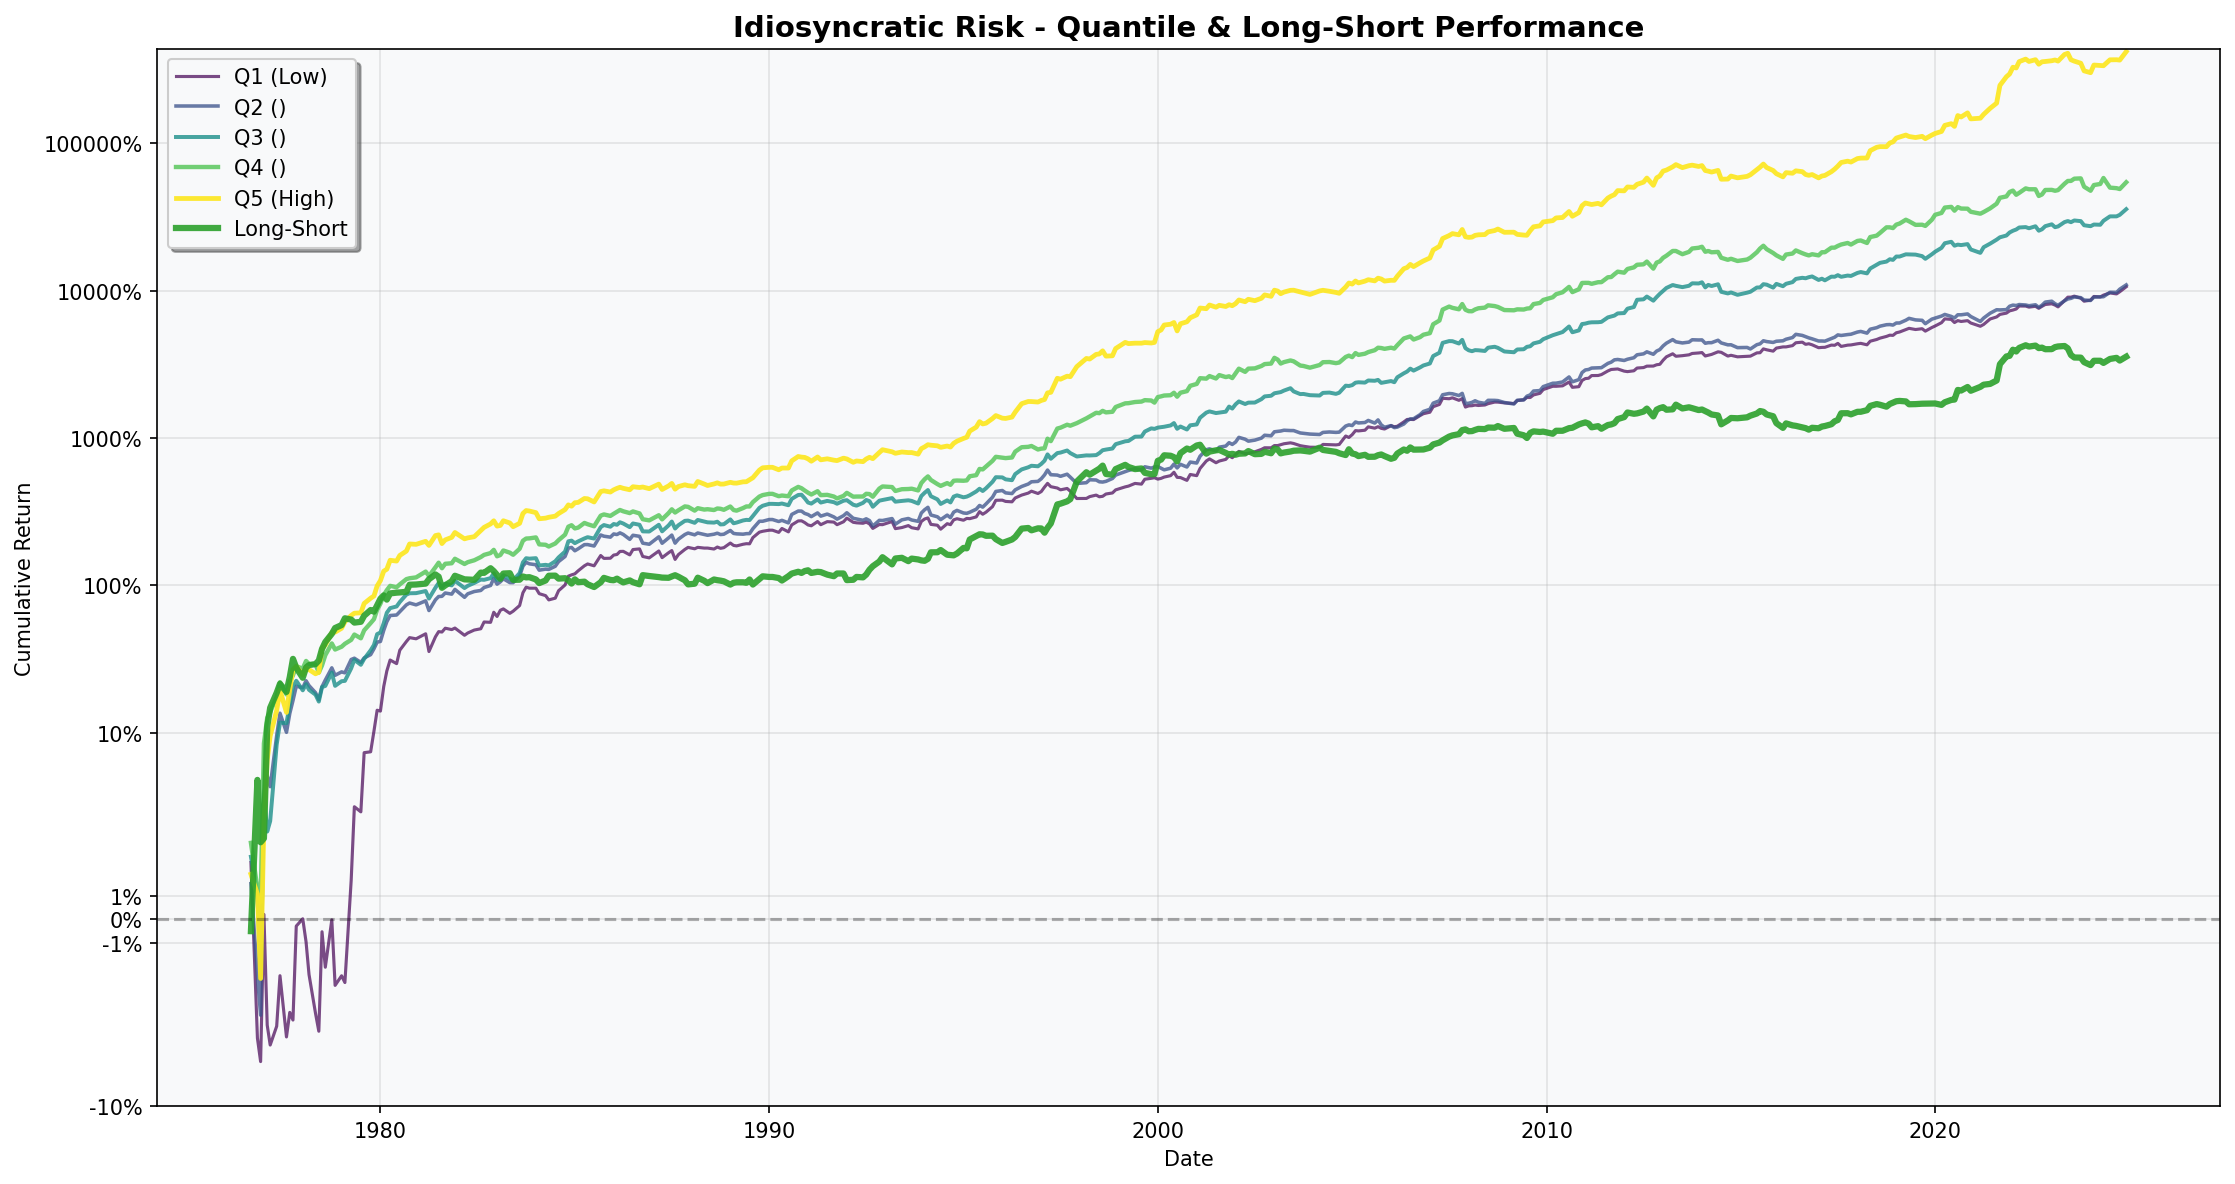

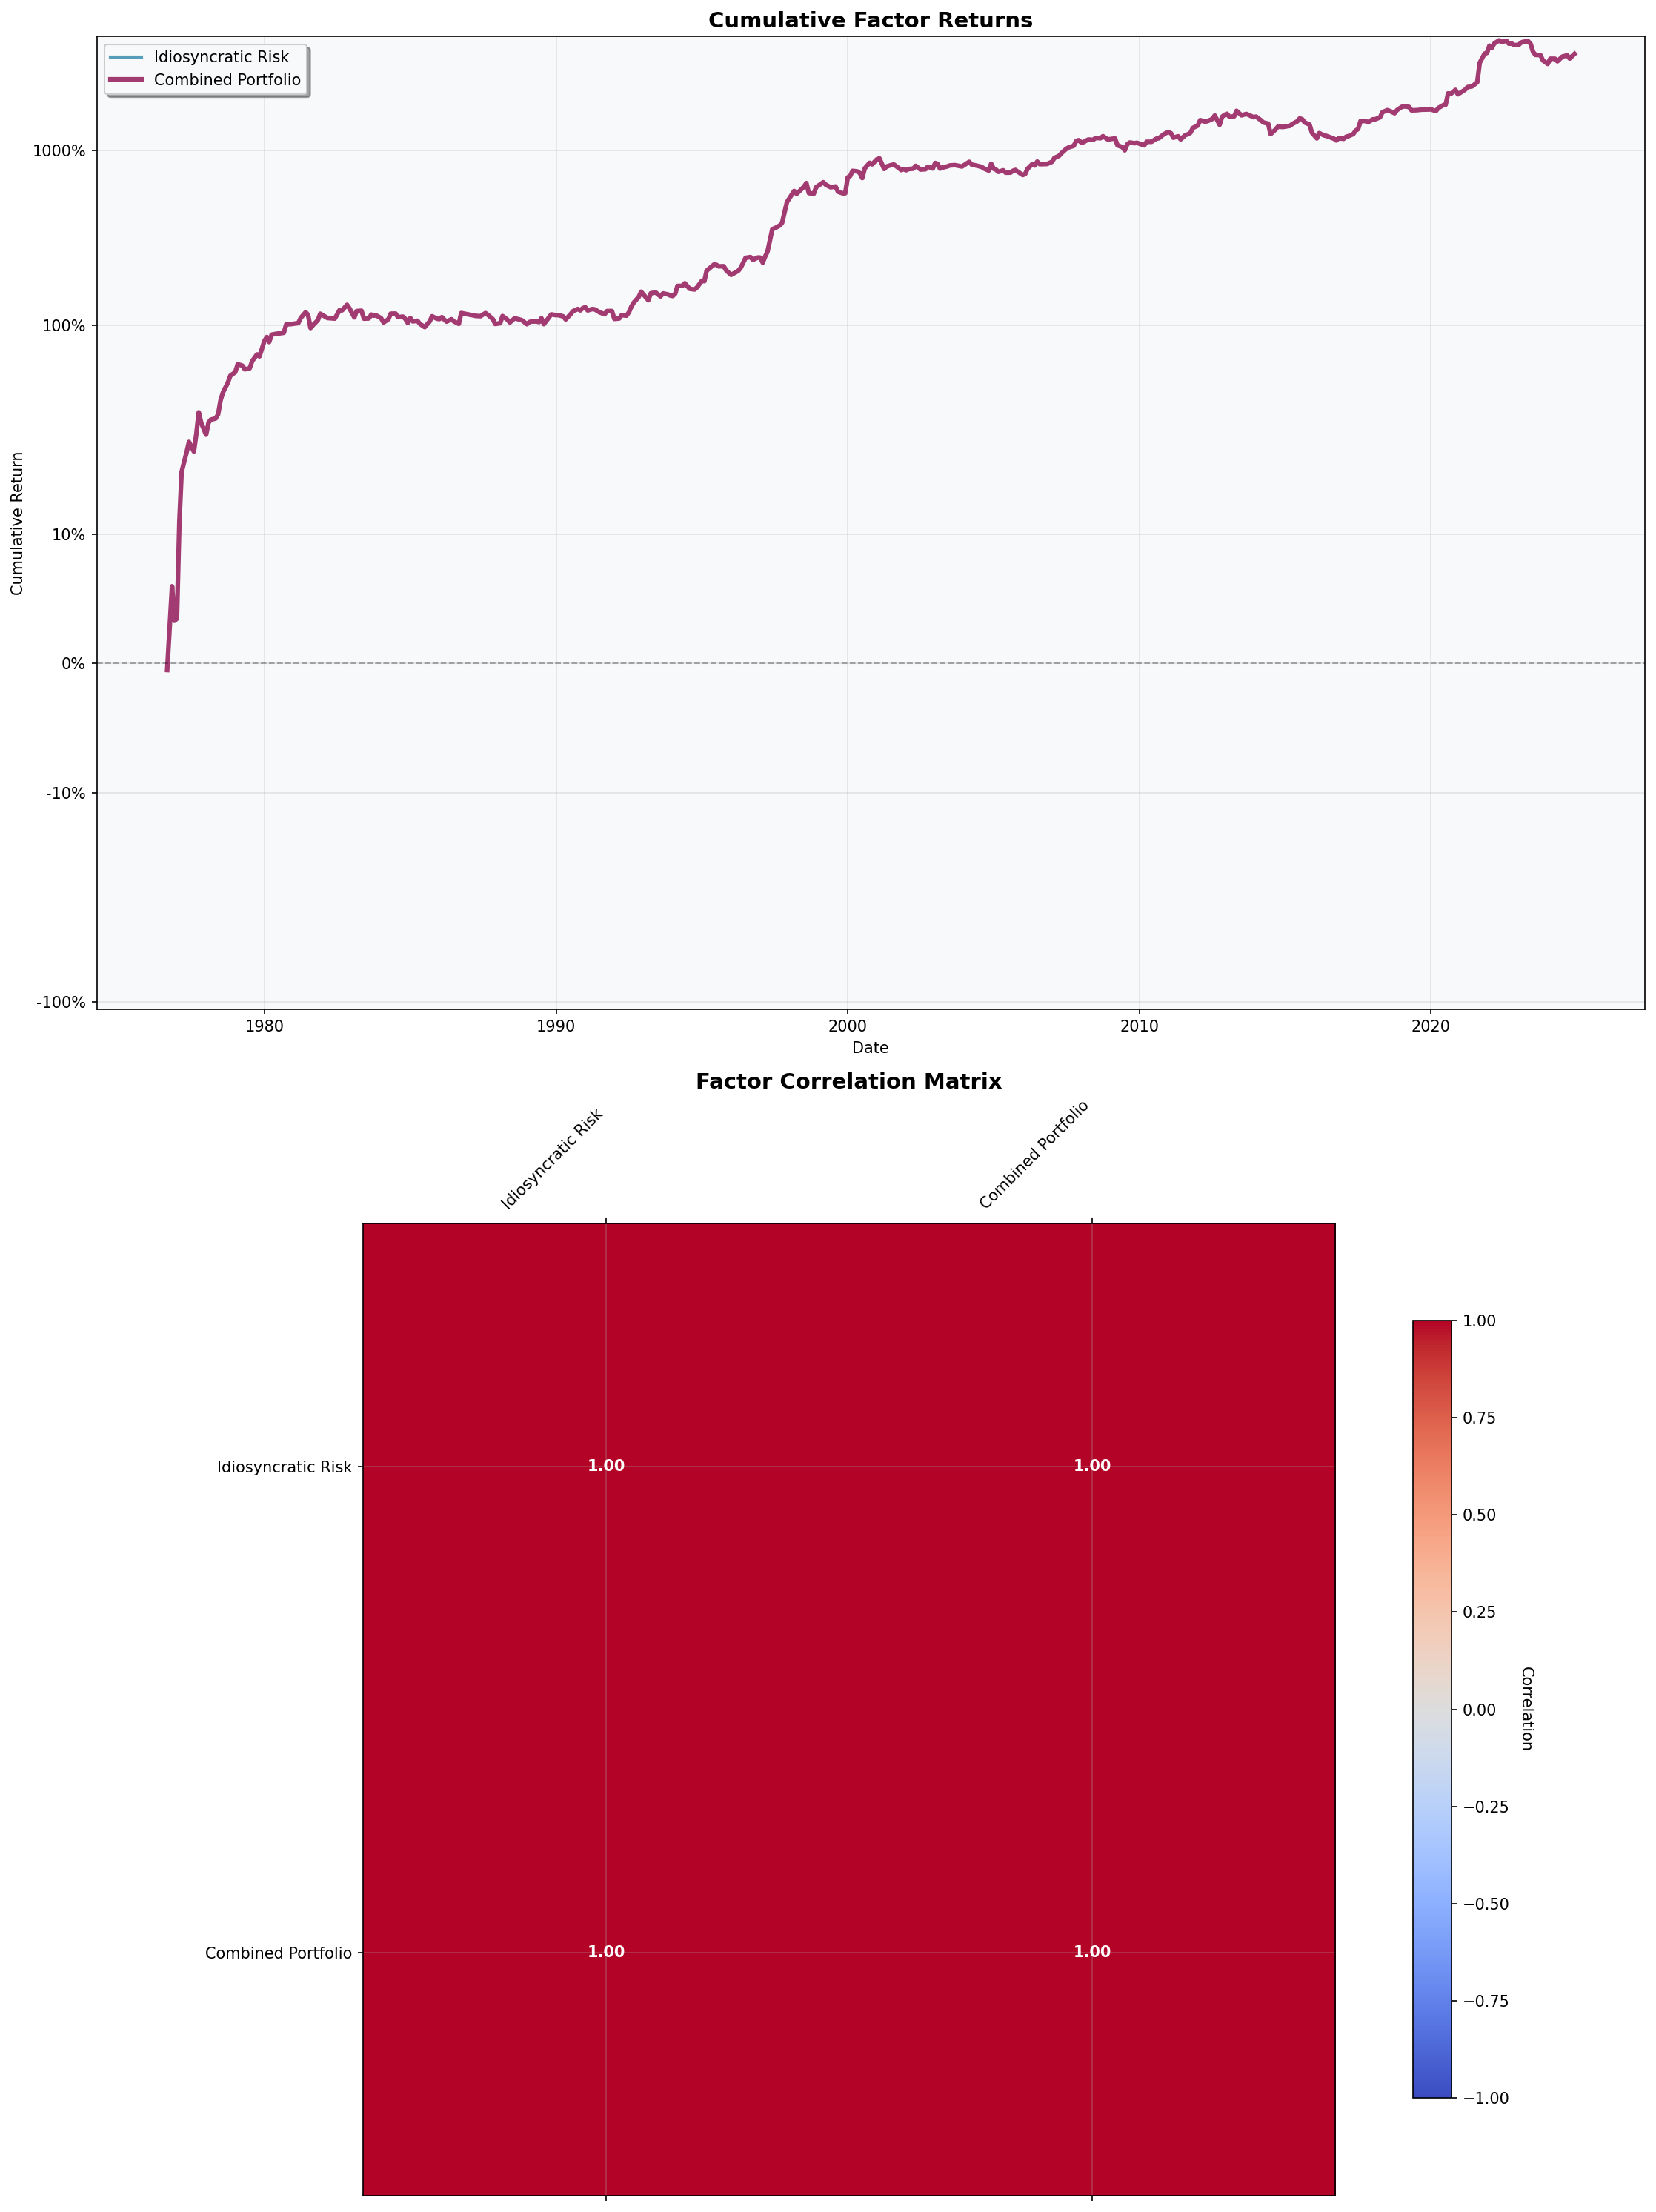

In [57]:
def ir_backtest_ew():
    model = FactorModel() # 1970 to 2024
    
    factor_names = ['idiosyncratic_risk']
    
    model.sort_into_quantiles(factor_names=factor_names, n_quantiles=5)
    model.backtest_all_factors_long_short(weighting='ew')
    model.analyze_performance()
    model.plot_factor_quantiles(factor_name='idiosyncratic_risk', weighting='ew')
    model.plot_performance(focus_factors=factor_names + ['combined_portfolio'])

ir_backtest_vw()